In [1752]:
from platform import python_version
print(python_version())

3.6.0


In [1753]:
import util, models

In [1760]:
importlib.reload(models)

<module 'models' from '/home/jrgillick/projects/assisted_orchestration/audio-feature-forecasting/src/models.py'>

In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import os, audioread, pretty_midi, librosa, numpy as np
import util
from tqdm import tqdm
from sklearn.utils import shuffle
from collections import defaultdict
from IPython.display import Audio as play
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import copy

In [4]:
#all_wav_files = shuffle(librosa.util.find_files('/data/jrgillick/projects/assisted_orchestration/TinySOL/TinySOL'))
all_wav_files = shuffle(librosa.util.find_files('/data/jrgillick/projects/assisted_orchestration/OrchDB/OrchDB_flat'))
len(all_wav_files)

19862

<h3> Explore some basic stats of the audio files </h3>

In [5]:
file_stats = []
for wav in tqdm(all_wav_files):
    with audioread.audio_open(wav) as f:
        file_stats.append([f.channels, f.samplerate, f.duration])

100%|██████████| 19862/19862 [01:46<00:00, 186.17it/s]


In [33]:
# Check number of channels (all should be mono) and sample rate
set([fs[0] for fs in file_stats]), set([fs[1] for fs in file_stats])

({1}, {44100})

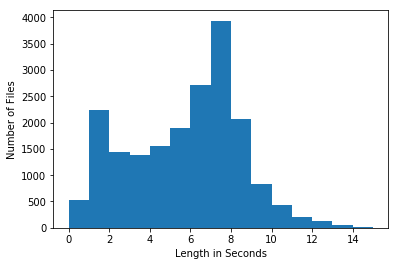

In [7]:
# plot the durations of the audio files
plt.ylabel('Number of Files')
plt.xlabel('Length in Seconds')
_ = plt.hist([fs[2] for fs in file_stats], bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

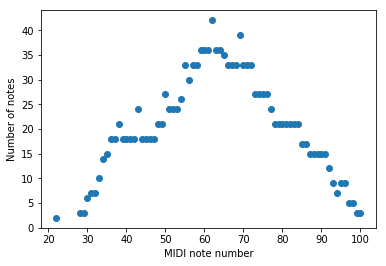

In [48]:
# check the pitches in the dataset

def get_tiny_sol_note_name(filename):
    return filename.split('/')[-1].split('-')[2]

# pull out the note name from the file string
def get_midi_pitch(filename):
    note_name = get_tiny_sol_note_name(filename)
    return(pretty_midi.note_name_to_number(note_name))

pitches = defaultdict(int)
for f in all_wav_files:
    pitches[get_midi_pitch(f)] += 1

plt.ylabel('Number of notes')
plt.xlabel('MIDI note number')
plt.scatter(pitches.keys(), pitches.values())

In [ ]:
# Methods to split out files by instrument, pitch, etc.

def get_instrument_type(filename):
    return filename.split('/')[-3]

def get_instrument(filename):
    return '/'.join(filename.split('/')[-3:-1])

def get_pitch_class(filename):
    return get_tiny_sol_note_name(filename)[0].lower()

def get_octave(filename):
    return get_tiny_sol_note_name(filename)[1].lower()

<h3> Compute some features - MFCC, FFT, etc.</h3>

In [12]:
def mix_n_sounds(sounds, coefs=None):
    if len(sounds) != len(coefs):
        raise("Need same # of sounds and mixture coefs")
        
    # Zero pad up to length of the longest file
    l = max([len(s) for s in sounds])
    sounds = [librosa.util.fix_length(s, l) for s in sounds]
    
    # if mixing coefficients are given, weight the sounds by those coefs
    if coefs is not None:
        weighted_sounds = [sounds[i]*coefs[i] for i in range(len(sounds))]
    
    # don't normalize, just divide by N
    return np.sum(weighted_sounds, axis=0)/len(sounds) 

In [223]:
def mean_squared_feature_distance(actual, forecast):    
    return np.sum(np.square(actual-forecast))/len(actual)

def mean_absolute_percentage_error(actual, forecast):
    return np.sum(np.abs ((actual - forecast) / actual)) / len (actual)

In [14]:
def real_stft(y):
    S, phase = librosa.magphase(librosa.stft(y))
    return S

def energy_weighted_fft(y):
    S, phase = librosa.magphase(librosa.stft(y))
    rms = librosa.feature.rmse(S=S)
    return np.sum(S*rms, axis=1)/np.sum(rms)
    
def energy_weighted_mfcc(y):
    S, phase = librosa.magphase(librosa.stft(y))
    rms = librosa.feature.rmse(S=S)
    mfcc = librosa.feature.mfcc(y, n_mfcc=20)[1:]
    return np.sum(mfcc*rms, axis=1)/np.sum(rms)

<h3> Data Version 1. Make training splits across all files, meaning don't partition by different instruments or pitches </h3>

In [15]:
split_1 = int(0.6 * len(all_wav_files))
split_2 = int(0.8 * len(all_wav_files))

train_files = np.array(all_wav_files[0:split_1])
dev_files = np.array(all_wav_files[split_1:split_2])
test_files = np.array(all_wav_files[split_2:])

In [16]:
# load in a list of wav files, cropping to max_duration
def get_all_signals(files):
    signals = []
    for f in tqdm(files):
        y, sr = librosa.load(f)
        signals.append(y)
    return signals

# Compute STFT and keep the magnitudes for a list of signals
def get_all_specs(signals):
    return [real_stft(signal) for signal in tqdm(signals)]

def get_all_weighted_ffts(signals):
    return [energy_weighted_fft(signal) for signal in tqdm(signals)]

def get_all_weighted_mfccs(signals):
    return [energy_weighted_mfcc(signal) for signal in tqdm(signals)]

def get_file_rms(signal):
    return np.sqrt(np.dot(signal, signal))/len(signal)

def get_all_energies(signals):
    return [get_file_rms(signal) for signal in tqdm(signals)]

In [ ]:
train_signals = get_all_signals(train_files)
dev_signals = get_all_signals(dev_files)
test_signals = get_all_signals(test_files)

 23%|██▎       | 2784/11917 [11:23<33:28,  4.55it/s]  

In [ ]:
train_signals = np.array(train_signals)
dev_signals = np.array(dev_signals)
test_signals = np.array(test_signals)

len(train_signals), len(dev_signals), len(test_signals)

In [ ]:
import pickle
with open('/data/jrgillick/projects/assisted_orchestration/train_signals.pkl', 'wb') as f:
    pickle.dump(train_signals, f)
    
with open('/data/jrgillick/projects/assisted_orchestration/dev_signals.pkl', 'wb') as f:
    pickle.dump(dev_signals, f)

In [ ]:
train_energies = get_all_energies(train_signals)
dev_energies = get_all_energies(dev_signals)
test_energies = get_all_energies(test_signals)

In [ ]:
train_weighted_ffts = get_all_weighted_ffts(train_signals)
dev_weighted_ffts = get_all_weighted_ffts(dev_signals)
test_weighted_ffts = get_all_weighted_ffts(test_signals)

In [ ]:
with open('/data/jrgillick/projects/assisted_orchestration/train_weighted_ffts.pkl', 'wb') as f:
    pickle.dump(train_weighted_ffts, f)
    
with open('/data/jrgillick/projects/assisted_orchestration/dev_weighted_ffts.pkl', 'wb') as f:
    pickle.dump(dev_weighted_ffts, f)
    
with open('/data/jrgillick/projects/assisted_orchestration/test_weighted_ffts.pkl', 'wb') as f:
    pickle.dump(test_weighted_ffts, f)

In [ ]:
train_weighted_mfccs = get_all_weighted_mfccs(train_signals)
dev_weighted_mfccs = get_all_weighted_mfccs(dev_signals)
test_weighted_mfccs = get_all_weighted_mfccs(test_signals)

In [ ]:
with open('/data/jrgillick/projects/assisted_orchestration/train_weighted_mfccs.pkl', 'wb') as f:
    pickle.dump(train_weighted_mfccs, f)
    
with open('/data/jrgillick/projects/assisted_orchestration/dev_weighted_mfccs.pkl', 'wb') as f:
    pickle.dump(dev_weighted_mfccs, f)
    
with open('/data/jrgillick/projects/assisted_orchestration/test_weighted_mfccs.pkl', 'wb') as f:
    pickle.dump(test_weighted_mfccs, f)

In [293]:
"""
train_weighted_ffts_scaled = copy.deepcopy(train_weighted_ffts)
dev_weighted_ffts_scaled = copy.deepcopy(dev_weighted_ffts)
test_weighted_ffts_scaled = copy.deepcopy(test_weighted_ffts)

fft_scaler = StandardScaler()
fft_scaler.fit(train_weighted_ffts_scaled)
train_weighted_ffts_scaled = fft_scaler.transform(train_weighted_ffts_scaled)
dev_weighted_ffts_scaled = fft_scaler.transform(dev_weighted_ffts_scaled)
test_weighted_ffts_scaled = fft_scaler.transform(test_weighted_ffts_scaled)
"""

In [294]:
"""
train_weighted_mfccs_scaled = copy.deepcopy(train_weighted_mfccs)
dev_weighted_mfccs_scaled = copy.deepcopy(dev_weighted_mfccs)
test_weighted_mfccs_scaled = copy.deepcopy(test_weighted_mfccs)

mfcc_scaler = StandardScaler()
mfcc_scaler.fit(train_weighted_mfccs_scaled)
train_weighted_mfccs_scaled = mfcc_scaler.transform(train_weighted_mfccs_scaled)
dev_weighted_mfccs_scaled = mfcc_scaler.transform(dev_weighted_mfccs_scaled)
test_weighted_mfccs_scaled = mfcc_scaler.transform(test_weighted_mfccs_scaled)
"""

In [ ]:
def make_mixes(source_signals, n_components, n_files, equal_weights = True):
    mixes = []
    components = []
    mixture_coefs = []
    for i in tqdm(range(n_files)):
        file_indices = np.random.choice(len(source_signals), n_components, replace=False)
        component_signals = source_signals[file_indices]
        if equal_weights:
            mixture_weights = np.ones(n_components)
        else:
            mixture_weights = np.random.uniform(0,1,n_components)
        mix = mix_n_sounds(component_signals, mixture_weights)

        
        mixes.append(mix)
        components.append(file_indices)
        mixture_coefs.append(mixture_weights)
    
    return mixes, components, mixture_coefs

In [ ]:
train_2_mixes, components, mixture_coefs = make_mixes(train_signals, 2, 100)

In [121]:
play(train_2_mixes[10],rate=sr)

In [269]:
comps = components[10]
l = max(len(train_signals[comps[0]]), len(train_signals[comps[1]]))
play([librosa.util.fix_length(train_signals[comps[0]],l),librosa.util.fix_length(train_signals[comps[1]], l)], rate=sr)

<h3> FFT/MFCC Experiments - Baseline </h3>
<h4> Here we want to predict the FFT of the mixture from the component FFT's. Since FFT is linear, the hypothesis is that as we increase the number of components, the error should be roughly linear </h4>

Steps:
<ol>
    <li> Create datasets with mixtures for 2,3,5,8,10,20 components </li>
    <li> Compute the "True" error for each number of components </li>
    <li> Train separate Feed-Forward models for each number of components </li>
    <li> Compare predicted errors to true errors and make plots </li>
    <li> (Later) - Train RNN to do the predictions so we only need one model </li>
    <li> (Later 2) - Replace the Fully Connected network with a CNN </li>
    <li> (Later 3) - Replace the model inputs with learned representations to avoid the averaging step </li>
</ol>

<h4> Step 1 </h4>
Create datasets with mixtures for 2,3,5,8,10,20 components. 10K examples per dataset for starters.

In [ ]:
mixture_values = [2,3,6,12,20,30,50]
num_train_datapoints = 7500
num_dev_datapoints = 2000
num_test_data_points = 10

train_mixture_datasets = defaultdict(None)
dev_mixture_datasets = defaultdict(None)
test_mixture_datasets = defaultdict(None)

In [ ]:
for m in mixture_values:
    # Train
    mixes, components, mixture_coefs = make_mixes(train_signals, m, num_train_datapoints)
    h = {'mixes': mixes, 'components': components, 'mixture_coefs': mixture_coefs}
    train_mixture_datasets[m] = h
    
    # Dev
    mixes, components, mixture_coefs = make_mixes(dev_signals, m, num_dev_datapoints)
    h = {'mixes': mixes, 'components': components, 'mixture_coefs': mixture_coefs}
    dev_mixture_datasets[m] = h

    # Test
    mixes, components, mixture_coefs = make_mixes(test_signals, m, num_test_data_points)
    h = {'mixes': mixes, 'components': components, 'mixture_coefs': mixture_coefs}
    test_mixture_datasets[m] = h

<h4> Step 2 </h4>
Compute the "True" error for each number of components

In [34]:
import pickle

In [38]:
del train_mixture_datasets

In [ ]:
# Compute the mixture FFT's for all datasets
for data in [train_mixture_datasets, dev_mixture_datasets, test_mixture_datasets]:
    for m in mixture_values:
        data[m]['mix_ffts'] = get_all_weighted_ffts(data[m]['mixes'])

In [ ]:
# Compute the mixture MFCC's for all datasets
for data in [train_mixture_datasets, dev_mixture_datasets, test_mixture_datasets]:
    for m in mixture_values:
        data[m]['mix_mfccs'] = get_all_weighted_mfccs(data[m]['mixes'])

In [ ]:
# Compute the mean mixture FFT's and MFCC's for all datasets to use as a baseline
for data in [train_mixture_datasets, dev_mixture_datasets, test_mixture_datasets]:
    for m in mixture_values:
        data[m]['mean_fft'] = np.mean(data[m]['mix_ffts'], axis=0)
        data[m]['mean_mfcc'] = np.mean(data[m]['mix_mfccs'], axis=0)

In [34]:
# scale the mixture features per dataset
#for data in [train_mixture_datasets, dev_mixture_datasets, test_mixture_datasets]:
#    for m in mixture_values:
#        scaled_mix_ffts = copy.deepcopy(data[m]['mix_mfccs'])
        

In [ ]:
_ = """
train_2 = train_mixture_datasets[2]
dev_2 = dev_mixture_datasets[2]
test_2 = test_mixture_datasets[2]

train_mix_weighted_ffts = [energy_weighted_fft(train_2['mixes'][i]) for i in tqdm(range(len(train_2['mixes'])))]
dev_mix_weighted_ffts = [energy_weighted_fft(dev_2['mixes'][i]) for i in tqdm(range(len(dev_2['mixes'])))]
test_mix_weighted_ffts = [energy_weighted_fft(test_2['mixes'][i]) for i in tqdm(range(len(test_2['mixes'])))]

play(train_2['mixes'][0], rate=sr)
play(train_signals[train_2['components'][0][0:2]], rate=sr)
"""

In [1750]:
def get_fft_mix_targets(dataset):
    return np.array(dataset['mix_ffts'])

def get_fft_inputs(dataset, source_ffts, flatten=True):
    datapoints = []
    component_lists = dataset['components']
    for component_indices in component_lists:
        fft_vectors = np.vstack([source_ffts[i] for i in component_indices])
        if flatten:
            fft_vectors = fft_vectors.reshape(-1)
        datapoints.append(fft_vectors)
    return np.array(datapoints)

In [415]:
m=20
X_train = copy.deepcopy(get_mfcc_inputs(train_mixture_datasets[m], train_weighted_mfccs, flatten=False))
y_train = copy.deepcopy(get_mfcc_mix_targets(train_mixture_datasets[m]))
X_train.shape, y_train.shape

((7500, 20, 19), (7500, 19))

In [497]:
# Train all lstm lengths together in one model with padded inputs
def get_padded_mfcc_inputs_and_targets(datasets_hash, source_mfccs):
    max_steps = max(mixture_values)
    padded_datasets = []
    targets = []
    for m in mixture_values:
        # get inputs
        d = datasets_hash[m]
        inputs = copy.deepcopy(get_mfcc_inputs(d, source_mfccs, flatten=False))
        padded = np.zeros((inputs.shape[0],max_steps,inputs.shape[2]))
        padded[:inputs.shape[0], :inputs.shape[1], :inputs.shape[2]] = inputs
        padded_datasets.append(padded)
        
        #get targets
        targets.append(copy.deepcopy(get_mfcc_mix_targets(datasets_hash[m])))
        
    return np.vstack(padded_datasets), np.vstack(targets)

# Train all lstm lengths together in one model with padded inputs
def get_padded_fft_inputs_and_targets(datasets_hash, source_ffts):
    max_steps = max(mixture_values)
    padded_datasets = []
    targets = []
    for m in mixture_values:
        # get inputs
        d = datasets_hash[m]
        inputs = copy.deepcopy(get_fft_inputs(d, source_ffts, flatten=False))
        #padded = np.zeros((inputs.shape[0],max_steps,inputs.shape[2]))
        #padded[:inputs.shape[0], :inputs.shape[1], :inputs.shape[2]] = inputs
        #padded_datasets.append(padded)
        #padded_datasets += list(padded)
        padded_datasets.append(inputs)
        
        #get targets
        targets.append(copy.deepcopy(get_fft_mix_targets(datasets_hash[m])))
        
    #return np.vstack(padded_datasets), np.vstack(targets)
    return padded_datasets, targets

In [615]:
x_t, y_t = get_padded_fft_inputs_and_targets(train_mixture_datasets, train_weighted_ffts)
x_d, y_d = get_padded_fft_inputs_and_targets(dev_mixture_datasets, dev_weighted_ffts)

In [626]:
def lstm_batch_generator(datasets, targets, batch_size=100, shuffle_sequence=False):
    # each dataset has the right shape
    while True:
        for d, t in zip(datasets, targets):
            i = 0
            while i < len(d):
                batch_inputs = d[i:i+batch_size]
                if shuffle_sequence:
                    shuffle_order(batch_inputs)
                batch_targets = t[i:i+batch_size]
                #print(batch_inputs[0].shape)
                i += batch_size
                yield(batch_inputs, batch_targets)
            #padded = np.zeros((inputs.shape[0],max_steps,inputs.shape[2]))
            
def lstm_batch_generator_sampling(datasets, targets, batch_size=100, shuffle_sequence=False):
    # each dataset has the right shape
    counter = 0
    # reshuffle each dataset every time this function gets called or after 500 batches
    for d, t in zip(datasets, targets):
        d, t = shuffle(d, t)
    while True:
        counter += 1
        # reshuffle each dataset after 500 batches
        if counter % 500 == 0:
            for d, t in zip(datasets, targets):
                d, t = shuffle(d, t)
        dataset_index = np.random.randint(len(datasets))
        d = datasets[dataset_index]
        t = targets[dataset_index]
        i = np.random.randint(len(d)-batch_size)
        batch_inputs = d[i:i+batch_size]
        if shuffle_sequence:
            shuffle_order(batch_inputs)
        batch_targets = t[i:i+batch_size]
        #print(batch_inputs[0].shape)
        #i += batch_size
        yield(batch_inputs, batch_targets)
        #padded = np.zeros((inputs.shape[0],max_steps,inputs.shape[2]))

In [656]:
lstm_together_model = models.fft_to_fft_lstm_model_together()

In [645]:
batch_size=250
epochs = 75
for e in range(epochs):
    #if e%5 == 10:
    #    print("Train Loss: ", lstm_together_model.evaluate_generator(lstm_batch_generator(x_t, y_t, batch_size=batch_size), steps=len(x_t)*len(x_t[0])/batch_size))
    print("Validation Loss: ", lstm_together_model.evaluate_generator(lstm_batch_generator(x_d, y_d, batch_size=batch_size), steps=len(x_d)*len(x_d[0])/batch_size))
    lstm_together_model.fit_generator(lstm_batch_generator_sampling(x_t, y_t, batch_size=batch_size, shuffle_sequence=True), steps_per_epoch=len(x_t)*len(x_t[0])/batch_size, epochs=1)

Validation Loss:  2.806716919477497
Epoch 1/1
210/210 [==============================] - 71s 339ms/step - loss: 2.0909
Validation Loss:  1.865241713688842
Epoch 1/1
210/210 [==============================] - 31s 146ms/step - loss: 1.8149
Validation Loss:  1.5285004062045897
Epoch 1/1
210/210 [==============================] - 33s 156ms/step - loss: 1.3258
Validation Loss:  1.3826849179874574
Epoch 1/1
210/210 [==============================] - 32s 154ms/step - loss: 1.3859
Validation Loss:  1.2731873016538364
Epoch 1/1
210/210 [==============================] - 31s 149ms/step - loss: 1.1722
Validation Loss:  1.208998642861843
Epoch 1/1
210/210 [==============================] - 30s 145ms/step - loss: 1.1813
Validation Loss:  1.1514637237414718
Epoch 1/1
210/210 [==============================] - 31s 145ms/step - loss: 1.2789
Validation Loss:  1.101186039458428
Epoch 1/1
210/210 [==============================] - 30s 144ms/step - loss: 1.0997
Validation Loss:  1.0801428517858898
Epoch 1

KeyboardInterrupt: 

In [ ]:
batch_size=125
epochs = 75
for e in range(epochs):
    #if e%5 == 10:
    #    print("Train Loss: ", lstm_together_model.evaluate_generator(lstm_batch_generator(x_t, y_t, batch_size=batch_size), steps=len(x_t)*len(x_t[0])/batch_size))
    print("Validation Loss: ", lstm_together_model.evaluate_generator(lstm_batch_generator(x_d, y_d, batch_size=batch_size), steps=len(x_d)*len(x_d[0])/batch_size))
    lstm_together_model.fit_generator(lstm_batch_generator_sampling(x_t, y_t, batch_size=batch_size, shuffle_sequence=True), steps_per_epoch=len(x_t)*len(x_t[0])/batch_size, epochs=1)

Validation Loss:  2.7987921830000624
Epoch 1/1
420/420 [==============================] - 85s 202ms/step - loss: 2.0935
Validation Loss:  1.6494481994637422
Epoch 1/1
420/420 [==============================] - 47s 112ms/step - loss: 1.4118
Validation Loss:  1.4106944450177252
Epoch 1/1
420/420 [==============================] - 45s 107ms/step - loss: 1.3044
Validation Loss:  1.2768090687958258
Epoch 1/1
420/420 [==============================] - 47s 112ms/step - loss: 1.2092
Validation Loss:  1.1901000027677842
Epoch 1/1
420/420 [==============================] - 45s 107ms/step - loss: 1.0487
Validation Loss:  1.155162741962288
Epoch 1/1
420/420 [==============================] - 46s 110ms/step - loss: 1.1435
Validation Loss:  1.0986480470746756
Epoch 1/1
420/420 [==============================] - 50s 118ms/step - loss: 1.0023
Validation Loss:  1.0700156686029263
Epoch 1/1
420/420 [==============================] - 44s 105ms/step - loss: 1.0782
Validation Loss:  1.0497549104371242
Epoc

In [654]:
print("Train Loss: ", lstm_together_model.evaluate_generator(lstm_batch_generator(x_t, y_t, batch_size=batch_size), steps=len(x_t)*len(x_t[0])/batch_size))

Train Loss:  0.6351581782279979


In [534]:
lstm_together_model.evaluate_generator(lstm_batch_generator(x_d, y_d), steps=len(x_d)*len(x_d[0])/batch_size)
pred_2 = lstm_together_model.predict()

(2000, 3, 1025)

In [294]:
#dev_weighted_ffts = copy.deepcopy(test_weighted_ffts)
#dev_weighted_mfccs = copy.deepcopy(test_weighted_mfccs)
#dev_energies = copy.deepcopy(test_energies)

In [358]:
def shuffle_order(X):
    for i in range(len(X)):
        np.random.shuffle(X[i])

In [ ]:
# Train LSTM models to predict MFCC from MFCC

loss_fn = 'mean_squared_error'

lstm_models = defaultdict(None)

# Train a separate model for each number of components
for m in mixture_values:
    print("Training model for %d components" % (m))
    lstm_models[m] = models.mfcc_to_mfcc_lstm_model(m, loss_fn=loss_fn)
    
    X_train = copy.deepcopy(get_mfcc_inputs(train_mixture_datasets[m], train_weighted_mfccs, flatten=False))
    y_train = copy.deepcopy(get_mfcc_mix_targets(train_mixture_datasets[m]))

    X_dev = copy.deepcopy(get_mfcc_inputs(dev_mixture_datasets[m], dev_weighted_mfccs, flatten=False))
    y_dev = copy.deepcopy(get_mfcc_mix_targets(dev_mixture_datasets[m]))

    epochs = 75
    for e in tqdm(range(epochs)):
        lstm_models[m].fit(X_train, y_train, validation_data=[X_dev, y_dev], batch_size=200, epochs=1)
        shuffle_order(X_train)

Training model for 2 components








  0%|          | 0/75 [00:00<?, ?it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 21s 3ms/step - loss: 944.8627 - val_loss: 803.8107








  1%|▏         | 1/75 [00:22<27:41, 22.46s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 109us/step - loss: 766.2016 - val_loss: 625.4305








  3%|▎         | 2/75 [00:23<19:26, 15.98s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 114us/step - loss: 608.1326 - val_loss: 475.9266








  4%|▍         | 3/75 [00:24<13:44, 11.46s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 113us/step - loss: 465.0545 - val_loss: 347.7379








  5%|▌         | 4/75 [00:25<09:48,  8.28s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 115us/step - loss: 347.3037 - val_loss: 261.0780








  7%|▋         | 5/75 [00:25<07:04,  6.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 109us/step - loss: 265.9142 - val_loss: 212.2433








  8%|▊         | 6/75 [00:26<05:10,  4.50s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 111us/step - loss: 214.3640 - val_loss: 189.3632








  9%|▉         | 7/75 [00:27<03:51,  3.41s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 108us/step - loss: 186.9861 - val_loss: 167.6973








 11%|█         | 8/75 [00:28<02:57,  2.64s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 111us/step - loss: 172.7457 - val_loss: 160.9423








 12%|█▏        | 9/75 [00:29<02:19,  2.11s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 108us/step - loss: 163.7819 - val_loss: 156.7634








 13%|█▎        | 10/75 [00:30<01:52,  1.73s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 112us/step - loss: 155.5844 - val_loss: 151.5130








 15%|█▍        | 11/75 [00:31<01:35,  1.49s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 114us/step - loss: 149.8120 - val_loss: 145.8337








 16%|█▌        | 12/75 [00:32<01:22,  1.31s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 112us/step - loss: 146.0097 - val_loss: 139.5927








 17%|█▋        | 13/75 [00:32<01:13,  1.18s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 113us/step - loss: 141.9923 - val_loss: 136.6774








 19%|█▊        | 14/75 [00:33<01:06,  1.09s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 108us/step - loss: 139.3552 - val_loss: 133.3131








 20%|██        | 15/75 [00:34<01:01,  1.02s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 110us/step - loss: 135.5663 - val_loss: 138.4194








 21%|██▏       | 16/75 [00:35<00:57,  1.03it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 110us/step - loss: 133.9851 - val_loss: 131.5815








 23%|██▎       | 17/75 [00:36<00:54,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 110us/step - loss: 130.6194 - val_loss: 128.7013








 24%|██▍       | 18/75 [00:37<00:52,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 113us/step - loss: 129.2644 - val_loss: 128.8542








 25%|██▌       | 19/75 [00:38<00:50,  1.10it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 112us/step - loss: 125.8260 - val_loss: 128.3171








 27%|██▋       | 20/75 [00:39<00:49,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 111us/step - loss: 125.1092 - val_loss: 123.2570








 28%|██▊       | 21/75 [00:39<00:48,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 110us/step - loss: 122.3553 - val_loss: 125.3186








 29%|██▉       | 22/75 [00:40<00:46,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 110us/step - loss: 121.8932 - val_loss: 122.7853








 31%|███       | 23/75 [00:41<00:45,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 111us/step - loss: 119.1169 - val_loss: 120.4800








 32%|███▏      | 24/75 [00:42<00:44,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 114us/step - loss: 116.6308 - val_loss: 117.7883








 33%|███▎      | 25/75 [00:43<00:44,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 115us/step - loss: 116.4434 - val_loss: 117.8420








 35%|███▍      | 26/75 [00:44<00:43,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 107us/step - loss: 115.4731 - val_loss: 119.0155








 36%|███▌      | 27/75 [00:45<00:41,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 113us/step - loss: 113.3091 - val_loss: 117.5798








 37%|███▋      | 28/75 [00:46<00:41,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 116us/step - loss: 113.3561 - val_loss: 115.6564








 39%|███▊      | 29/75 [00:46<00:40,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 114us/step - loss: 110.6367 - val_loss: 117.0496








 40%|████      | 30/75 [00:47<00:39,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 109us/step - loss: 110.3591 - val_loss: 114.6468








 41%|████▏     | 31/75 [00:48<00:38,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 112us/step - loss: 109.5262 - val_loss: 115.9469








 43%|████▎     | 32/75 [00:49<00:37,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 115us/step - loss: 107.5769 - val_loss: 113.9695








 44%|████▍     | 33/75 [00:50<00:37,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 111us/step - loss: 106.6668 - val_loss: 112.8017








 45%|████▌     | 34/75 [00:51<00:36,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 112us/step - loss: 105.7124 - val_loss: 112.7290








 47%|████▋     | 35/75 [00:52<00:35,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 112us/step - loss: 103.6775 - val_loss: 111.8296








 48%|████▊     | 36/75 [00:53<00:34,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 115us/step - loss: 103.6295 - val_loss: 112.1932








 49%|████▉     | 37/75 [00:53<00:33,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 114us/step - loss: 104.0222 - val_loss: 114.2078








 51%|█████     | 38/75 [00:54<00:32,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 116us/step - loss: 102.2067 - val_loss: 109.3144








 52%|█████▏    | 39/75 [00:55<00:32,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 111us/step - loss: 100.0573 - val_loss: 110.5911








 53%|█████▎    | 40/75 [00:56<00:31,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 109us/step - loss: 98.8783 - val_loss: 111.0606








 55%|█████▍    | 41/75 [00:57<00:29,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 105us/step - loss: 98.1273 - val_loss: 110.7162








 56%|█████▌    | 42/75 [00:58<00:28,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 114us/step - loss: 98.1272 - val_loss: 110.8795








 57%|█████▋    | 43/75 [00:59<00:27,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 110us/step - loss: 96.5591 - val_loss: 108.9213








 59%|█████▊    | 44/75 [01:00<00:27,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 114us/step - loss: 95.9030 - val_loss: 112.6943








 60%|██████    | 45/75 [01:01<00:26,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 116us/step - loss: 95.0480 - val_loss: 111.5723








 61%|██████▏   | 46/75 [01:01<00:25,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 112us/step - loss: 95.7066 - val_loss: 112.5100








 63%|██████▎   | 47/75 [01:02<00:24,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 113us/step - loss: 94.8578 - val_loss: 106.8465








 64%|██████▍   | 48/75 [01:03<00:23,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 104us/step - loss: 93.6139 - val_loss: 106.4922








 65%|██████▌   | 49/75 [01:04<00:22,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 112us/step - loss: 92.1619 - val_loss: 109.1382








 67%|██████▋   | 50/75 [01:05<00:21,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 117us/step - loss: 92.3261 - val_loss: 112.1842








 68%|██████▊   | 51/75 [01:06<00:21,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 118us/step - loss: 90.0154 - val_loss: 106.4516








 69%|██████▉   | 52/75 [01:07<00:20,  1.11it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 113us/step - loss: 90.8470 - val_loss: 108.6768








 71%|███████   | 53/75 [01:08<00:19,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 110us/step - loss: 89.3562 - val_loss: 107.0273








 72%|███████▏  | 54/75 [01:09<00:18,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 105us/step - loss: 87.9381 - val_loss: 108.7325








 73%|███████▎  | 55/75 [01:09<00:17,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 114us/step - loss: 87.5481 - val_loss: 107.0126








 75%|███████▍  | 56/75 [01:10<00:16,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 114us/step - loss: 87.5939 - val_loss: 106.3704








 76%|███████▌  | 57/75 [01:11<00:15,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 110us/step - loss: 87.9563 - val_loss: 106.4614








 77%|███████▋  | 58/75 [01:12<00:14,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 114us/step - loss: 86.3728 - val_loss: 110.1241








 79%|███████▊  | 59/75 [01:13<00:14,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 112us/step - loss: 87.5551 - val_loss: 107.8866








 80%|████████  | 60/75 [01:14<00:13,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 115us/step - loss: 86.3606 - val_loss: 104.8549








 81%|████████▏ | 61/75 [01:15<00:12,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 115us/step - loss: 84.7890 - val_loss: 105.0308








 83%|████████▎ | 62/75 [01:16<00:11,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 113us/step - loss: 85.0205 - val_loss: 104.6696








 84%|████████▍ | 63/75 [01:16<00:10,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 112us/step - loss: 83.7650 - val_loss: 102.7845








 85%|████████▌ | 64/75 [01:17<00:09,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 116us/step - loss: 84.1020 - val_loss: 106.5435








 87%|████████▋ | 65/75 [01:18<00:08,  1.11it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 108us/step - loss: 83.2098 - val_loss: 103.6434








 88%|████████▊ | 66/75 [01:19<00:07,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 113us/step - loss: 83.2629 - val_loss: 105.6967








 89%|████████▉ | 67/75 [01:20<00:07,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 111us/step - loss: 83.1851 - val_loss: 103.4119








 91%|█████████ | 68/75 [01:21<00:06,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 114us/step - loss: 81.6890 - val_loss: 104.2034








 92%|█████████▏| 69/75 [01:22<00:05,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 112us/step - loss: 81.7465 - val_loss: 103.9983








 93%|█████████▎| 70/75 [01:23<00:04,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 108us/step - loss: 80.5454 - val_loss: 103.3643








 95%|█████████▍| 71/75 [01:24<00:03,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 115us/step - loss: 81.0859 - val_loss: 108.3325








 96%|█████████▌| 72/75 [01:24<00:02,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 114us/step - loss: 81.3960 - val_loss: 105.1036








 97%|█████████▋| 73/75 [01:25<00:01,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 113us/step - loss: 80.2584 - val_loss: 104.4523








 99%|█████████▊| 74/75 [01:26<00:00,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 115us/step - loss: 79.3230 - val_loss: 102.8329








100%|██████████| 75/75 [01:27<00:00,  1.13it/s]

Training model for 3 components








  0%|          | 0/75 [00:00<?, ?it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 22s 3ms/step - loss: 932.6903 - val_loss: 828.4464








  1%|▏         | 1/75 [00:24<30:11, 24.48s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 128us/step - loss: 772.4240 - val_loss: 675.8394








  3%|▎         | 2/75 [00:25<21:12, 17.44s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 131us/step - loss: 630.4794 - val_loss: 526.8385








  4%|▍         | 3/75 [00:26<15:01, 12.51s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 137us/step - loss: 496.1161 - val_loss: 392.6120








  5%|▌         | 4/75 [00:27<10:44,  9.08s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 140us/step - loss: 378.9899 - val_loss: 295.6568








  7%|▋         | 5/75 [00:28<07:48,  6.69s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 130us/step - loss: 291.4080 - val_loss: 232.7223








  8%|▊         | 6/75 [00:29<05:43,  4.99s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 133us/step - loss: 234.4693 - val_loss: 196.4067








  9%|▉         | 7/75 [00:30<04:18,  3.81s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 138us/step - loss: 204.3682 - val_loss: 186.0546








 11%|█         | 8/75 [00:31<03:20,  2.99s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 131us/step - loss: 188.0448 - val_loss: 176.4013








 12%|█▏        | 9/75 [00:32<02:38,  2.41s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 138us/step - loss: 178.5129 - val_loss: 171.2177








 13%|█▎        | 10/75 [00:33<02:10,  2.01s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 137us/step - loss: 171.6614 - val_loss: 171.2715








 15%|█▍        | 11/75 [00:35<01:50,  1.73s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 141us/step - loss: 166.9877 - val_loss: 166.4305








 16%|█▌        | 12/75 [00:36<01:37,  1.54s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 136us/step - loss: 162.7447 - val_loss: 161.1730








 17%|█▋        | 13/75 [00:37<01:26,  1.40s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 134us/step - loss: 159.7187 - val_loss: 157.6386








 19%|█▊        | 14/75 [00:38<01:19,  1.30s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 131us/step - loss: 155.6633 - val_loss: 157.6877








 20%|██        | 15/75 [00:39<01:13,  1.22s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 134us/step - loss: 153.2532 - val_loss: 154.2069








 21%|██▏       | 16/75 [00:40<01:08,  1.17s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 133us/step - loss: 150.5997 - val_loss: 153.4770








 23%|██▎       | 17/75 [00:41<01:05,  1.13s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 138us/step - loss: 147.9642 - val_loss: 150.1152








 24%|██▍       | 18/75 [00:42<01:03,  1.12s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 134us/step - loss: 145.5040 - val_loss: 149.4284








 25%|██▌       | 19/75 [00:43<01:01,  1.10s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 131us/step - loss: 144.8324 - val_loss: 146.4641








 27%|██▋       | 20/75 [00:44<00:59,  1.08s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 136us/step - loss: 141.0226 - val_loss: 145.8817








 28%|██▊       | 21/75 [00:45<00:58,  1.08s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 128us/step - loss: 138.9596 - val_loss: 143.9224








 29%|██▉       | 22/75 [00:46<00:56,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 133us/step - loss: 136.8511 - val_loss: 143.2556








 31%|███       | 23/75 [00:47<00:55,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 136us/step - loss: 135.8159 - val_loss: 142.8559








 32%|███▏      | 24/75 [00:48<00:54,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 128us/step - loss: 133.3475 - val_loss: 141.9461








 33%|███▎      | 25/75 [00:49<00:52,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 129us/step - loss: 132.5673 - val_loss: 141.6658








 35%|███▍      | 26/75 [00:50<00:50,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 133us/step - loss: 131.3327 - val_loss: 141.7435








 36%|███▌      | 27/75 [00:51<00:50,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 138us/step - loss: 129.8210 - val_loss: 139.2512








 37%|███▋      | 28/75 [00:52<00:49,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 137us/step - loss: 129.3174 - val_loss: 138.2084








 39%|███▊      | 29/75 [00:54<00:48,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 133us/step - loss: 127.0244 - val_loss: 140.1321








 40%|████      | 30/75 [00:55<00:47,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 133us/step - loss: 126.2525 - val_loss: 140.4475








 41%|████▏     | 31/75 [00:56<00:46,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 134us/step - loss: 124.3501 - val_loss: 135.4197








 43%|████▎     | 32/75 [00:57<00:45,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 138us/step - loss: 123.9504 - val_loss: 135.8195








 44%|████▍     | 33/75 [00:58<00:44,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 132us/step - loss: 122.3498 - val_loss: 135.5936








 45%|████▌     | 34/75 [00:59<00:43,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 136us/step - loss: 121.2558 - val_loss: 135.3283








 47%|████▋     | 35/75 [01:00<00:42,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 130us/step - loss: 120.1551 - val_loss: 137.3885








 48%|████▊     | 36/75 [01:01<00:41,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 134us/step - loss: 120.0330 - val_loss: 133.4266








 49%|████▉     | 37/75 [01:02<00:40,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 138us/step - loss: 118.8337 - val_loss: 132.4245








 51%|█████     | 38/75 [01:03<00:39,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 137us/step - loss: 117.2096 - val_loss: 134.3532








 52%|█████▏    | 39/75 [01:04<00:38,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 131us/step - loss: 116.2884 - val_loss: 136.3284








 53%|█████▎    | 40/75 [01:05<00:36,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 129us/step - loss: 115.6993 - val_loss: 137.6365








 55%|█████▍    | 41/75 [01:06<00:35,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 136us/step - loss: 113.6382 - val_loss: 130.6915








 56%|█████▌    | 42/75 [01:07<00:34,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 138us/step - loss: 114.0634 - val_loss: 133.2970








 57%|█████▋    | 43/75 [01:08<00:33,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 135us/step - loss: 113.5763 - val_loss: 136.0883








 59%|█████▊    | 44/75 [01:09<00:32,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 138us/step - loss: 111.4214 - val_loss: 131.2930








 60%|██████    | 45/75 [01:11<00:32,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 139us/step - loss: 110.5102 - val_loss: 134.8850








 61%|██████▏   | 46/75 [01:12<00:31,  1.08s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 133us/step - loss: 110.4239 - val_loss: 129.9972








 63%|██████▎   | 47/75 [01:13<00:29,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 129us/step - loss: 109.6584 - val_loss: 134.2970








 64%|██████▍   | 48/75 [01:14<00:28,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 137us/step - loss: 108.8835 - val_loss: 130.5638








 65%|██████▌   | 49/75 [01:15<00:27,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 133us/step - loss: 107.7477 - val_loss: 130.5079








 67%|██████▋   | 50/75 [01:16<00:26,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 127us/step - loss: 107.6894 - val_loss: 128.5459








 68%|██████▊   | 51/75 [01:17<00:25,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 137us/step - loss: 107.7994 - val_loss: 130.2540








 69%|██████▉   | 52/75 [01:18<00:24,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 137us/step - loss: 106.2978 - val_loss: 132.6254








 71%|███████   | 53/75 [01:19<00:23,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 126us/step - loss: 107.0786 - val_loss: 127.7742








 72%|███████▏  | 54/75 [01:20<00:21,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 135us/step - loss: 105.0318 - val_loss: 127.3169








 73%|███████▎  | 55/75 [01:21<00:21,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 133us/step - loss: 105.3669 - val_loss: 128.4322








 75%|███████▍  | 56/75 [01:22<00:19,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 137us/step - loss: 104.5532 - val_loss: 132.7352








 76%|███████▌  | 57/75 [01:23<00:19,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 136us/step - loss: 103.8282 - val_loss: 130.2487








 77%|███████▋  | 58/75 [01:24<00:17,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 133us/step - loss: 102.5868 - val_loss: 125.9175








 79%|███████▊  | 59/75 [01:25<00:16,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 136us/step - loss: 102.5355 - val_loss: 131.2850








 80%|████████  | 60/75 [01:26<00:15,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 135us/step - loss: 101.1929 - val_loss: 126.5953








 81%|████████▏ | 61/75 [01:27<00:14,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 138us/step - loss: 101.2763 - val_loss: 133.6218








 83%|████████▎ | 62/75 [01:28<00:13,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 137us/step - loss: 100.7798 - val_loss: 125.9684








 84%|████████▍ | 63/75 [01:30<00:12,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 135us/step - loss: 100.5337 - val_loss: 130.0501








 85%|████████▌ | 64/75 [01:31<00:11,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 135us/step - loss: 100.6135 - val_loss: 126.8195








 87%|████████▋ | 65/75 [01:32<00:10,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 130us/step - loss: 99.3631 - val_loss: 128.9199








 88%|████████▊ | 66/75 [01:33<00:09,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 131us/step - loss: 100.2619 - val_loss: 129.9723








 89%|████████▉ | 67/75 [01:34<00:08,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 130us/step - loss: 98.5363 - val_loss: 125.2946








 91%|█████████ | 68/75 [01:35<00:07,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 131us/step - loss: 98.3276 - val_loss: 126.2363








 92%|█████████▏| 69/75 [01:36<00:06,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 137us/step - loss: 97.4442 - val_loss: 126.4543








 93%|█████████▎| 70/75 [01:37<00:05,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 139us/step - loss: 96.3592 - val_loss: 126.2258








 95%|█████████▍| 71/75 [01:38<00:04,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 134us/step - loss: 97.2267 - val_loss: 125.4824








 96%|█████████▌| 72/75 [01:39<00:03,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 134us/step - loss: 97.0584 - val_loss: 125.9873








 97%|█████████▋| 73/75 [01:40<00:02,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 140us/step - loss: 96.2711 - val_loss: 130.6931








 99%|█████████▊| 74/75 [01:41<00:01,  1.08s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 137us/step - loss: 95.4469 - val_loss: 126.1924








100%|██████████| 75/75 [01:42<00:00,  1.08s/it]

Training model for 6 components








  0%|          | 0/75 [00:00<?, ?it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1


In [1763]:
5

5

In [ ]:
# Train LSTM models to predict FFT from FFT

loss_fn = 'mean_squared_error'

fft_lstm_models_positive = defaultdict(None)

# Train a separate model for each number of components
for m in mixture_values:
    print("Training model for %d components" % (m))
    fft_lstm_models_positive[m] = models.fft_to_fft_lstm_model(m, loss_fn=loss_fn)
    
    X_train = copy.deepcopy(get_fft_inputs(train_mixture_datasets[m], train_weighted_ffts, flatten=False))
    y_train = copy.deepcopy(get_fft_mix_targets(train_mixture_datasets[m]))

    X_dev = copy.deepcopy(get_fft_inputs(dev_mixture_datasets[m], dev_weighted_ffts, flatten=False))
    y_dev = copy.deepcopy(get_fft_mix_targets(dev_mixture_datasets[m]))

    epochs = 75
    for e in range(epochs):
        fft_lstm_models_positive[m].fit(X_train, y_train, validation_data=[X_dev, y_dev], batch_size=200, epochs=1)
        shuffle_order(X_train)

Training model for 2 components
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 53s 7ms/step - loss: 8.7127 - val_loss: 7.9573
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 149us/step - loss: 7.8893 - val_loss: 7.0178
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 149us/step - loss: 6.9449 - val_loss: 6.0701
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 147us/step - loss: 6.0041 - val_loss: 5.2883
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 153us/step - loss: 5.2178 - val_loss: 4.6344
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 145us/step - loss: 4.6124 - val_loss: 4.1160
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/

7500/7500 [==============================] - 1s 146us/step - loss: 1.6749 - val_loss: 1.7045
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 144us/step - loss: 1.6569 - val_loss: 1.7046
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 148us/step - loss: 1.6720 - val_loss: 1.7129
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 150us/step - loss: 1.6244 - val_loss: 1.7241
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 148us/step - loss: 1.6193 - val_loss: 1.7113
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 145us/step - loss: 1.6161 - val_loss: 1.7025
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 144us/step - loss: 1.6051 - val_loss: 1.7165
T

7500/7500 [==============================] - 1s 196us/step - loss: 1.2413 - val_loss: 1.2735
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 200us/step - loss: 1.2389 - val_loss: 1.2647
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 195us/step - loss: 1.2389 - val_loss: 1.2569
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 197us/step - loss: 1.2160 - val_loss: 1.2545
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 195us/step - loss: 1.2201 - val_loss: 1.2453
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 191us/step - loss: 1.2239 - val_loss: 1.2442
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 191us/step - loss: 1.2032 - val_loss: 1.2418
T

7500/7500 [==============================] - 2s 320us/step - loss: 0.7607 - val_loss: 0.6954
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 2s 318us/step - loss: 0.7486 - val_loss: 0.6861
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 2s 322us/step - loss: 0.7407 - val_loss: 0.6759
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 2s 320us/step - loss: 0.7287 - val_loss: 0.6665
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 2s 322us/step - loss: 0.7132 - val_loss: 0.6597
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 2s 321us/step - loss: 0.6980 - val_loss: 0.6528
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 2s 323us/step - loss: 0.6936 - val_loss: 0.6448
T

7500/7500 [==============================] - 2s 321us/step - loss: 0.5504 - val_loss: 0.5787
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 2s 322us/step - loss: 0.5495 - val_loss: 0.5787
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 2s 317us/step - loss: 0.5480 - val_loss: 0.5808
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 2s 321us/step - loss: 0.5493 - val_loss: 0.5793
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 2s 321us/step - loss: 0.5462 - val_loss: 0.5827
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 2s 319us/step - loss: 0.5454 - val_loss: 0.5790
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 2s 320us/step - loss: 0.5425 - val_loss: 0.5782
T

7500/7500 [==============================] - 4s 565us/step - loss: 0.2719 - val_loss: 0.2611
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 4s 569us/step - loss: 0.2710 - val_loss: 0.2605
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 4s 569us/step - loss: 0.2708 - val_loss: 0.2596
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 4s 569us/step - loss: 0.2674 - val_loss: 0.2567
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 4s 563us/step - loss: 0.2692 - val_loss: 0.2593
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 4s 570us/step - loss: 0.2674 - val_loss: 0.2574
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 4s 569us/step - loss: 0.2661 - val_loss: 0.2572
T

7500/7500 [==============================] - 7s 896us/step - loss: 0.1616 - val_loss: 0.1427
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 7s 900us/step - loss: 0.1604 - val_loss: 0.1423
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 7s 892us/step - loss: 0.1590 - val_loss: 0.1418
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 7s 897us/step - loss: 0.1575 - val_loss: 0.1414
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 7s 896us/step - loss: 0.1565 - val_loss: 0.1397
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 7s 895us/step - loss: 0.1553 - val_loss: 0.1394
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 7s 890us/step - loss: 0.1541 - val_loss: 0.1389
T

7500/7500 [==============================] - 10s 1ms/step - loss: 0.1812 - val_loss: 0.1621
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 10s 1ms/step - loss: 0.1682 - val_loss: 0.1461
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 10s 1ms/step - loss: 0.1564 - val_loss: 0.1348
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 10s 1ms/step - loss: 0.1470 - val_loss: 0.1259
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 10s 1ms/step - loss: 0.1393 - val_loss: 0.1178
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 10s 1ms/step - loss: 0.1326 - val_loss: 0.1125
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 10s 1ms/step - loss: 0.1275 - val_loss: 0.1077
Train on

7500/7500 [==============================] - 10s 1ms/step - loss: 0.0789 - val_loss: 0.0740
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0785 - val_loss: 0.0740
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0781 - val_loss: 0.0734
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
3400/7500 [============>.................] - ETA: 4s - loss: 0.0781

In [657]:
# Train TWO LAYER MLP models to predict MFCC from MFCC

loss_fn = 'mean_squared_error'

mlp_models_two_layer = defaultdict(None)

# Train a separate model for each number of components
for m in mixture_values:
    print("Training model for %d components" % (m))
    mlp_models_two_layer[m] = models.mfcc_to_mfcc_model_two_layer(m, loss_fn=loss_fn)
    
    X_train = copy.deepcopy(get_mfcc_inputs(train_mixture_datasets[m], train_weighted_mfccs))
    y_train = copy.deepcopy(get_mfcc_mix_targets(train_mixture_datasets[m]))
    
    #X_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    
    #X_scaler.fit(X_train)
    #y_scaler.fit(y_train)

    X_dev = copy.deepcopy(get_mfcc_inputs(dev_mixture_datasets[m], dev_weighted_mfccs))
    y_dev = copy.deepcopy(get_mfcc_mix_targets(dev_mixture_datasets[m]))
    
    #X_train = X_scaler.transform(X_train)
    #X_dev = X_scaler.transform(X_dev)
    #y_train = y_scaler.transform(y_train)
    #y_dev = y_scaler.transform(y_dev)

    epochs = 75
    for e in tqdm(range(epochs)):
        mlp_models_two_layer[m].fit(X_train, y_train, validation_data=[X_dev, y_dev], batch_size=200, epochs=1)
        shuffle_order(X_train)

Training model for 2 components








  0%|          | 0/75 [00:00<?, ?it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 45s 6ms/step - loss: 964.9917 - val_loss: 848.9574








  1%|▏         | 1/75 [00:46<57:23, 46.53s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 919.1237 - val_loss: 672.6197








  3%|▎         | 2/75 [00:47<39:55, 32.82s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 834.2098 - val_loss: 629.4372








  4%|▍         | 3/75 [00:48<27:51, 23.22s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 762.4415 - val_loss: 567.5107








  5%|▌         | 4/75 [00:48<19:31, 16.50s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 690.5851 - val_loss: 508.7504








  7%|▋         | 5/75 [00:49<13:46, 11.80s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 620.4923 - val_loss: 442.0050








  8%|▊         | 6/75 [00:50<09:46,  8.50s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 556.3864 - val_loss: 453.0848








  9%|▉         | 7/75 [00:51<07:01,  6.20s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 502.1925 - val_loss: 370.0354








 11%|█         | 8/75 [00:52<05:08,  4.61s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 456.7537 - val_loss: 356.6849








 12%|█▏        | 9/75 [00:53<03:49,  3.48s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 421.9267 - val_loss: 363.8228








 13%|█▎        | 10/75 [00:54<02:55,  2.70s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 399.3105 - val_loss: 360.5104








 15%|█▍        | 11/75 [00:54<02:17,  2.15s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 385.3012 - val_loss: 346.8711








 16%|█▌        | 12/75 [00:55<01:48,  1.72s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 376.9912 - val_loss: 337.4023








 17%|█▋        | 13/75 [00:56<01:30,  1.45s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 370.9505 - val_loss: 352.3120








 19%|█▊        | 14/75 [00:57<01:17,  1.28s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 367.9779 - val_loss: 354.4728








 20%|██        | 15/75 [00:58<01:09,  1.16s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 368.0560 - val_loss: 336.0791








 21%|██▏       | 16/75 [00:59<01:03,  1.07s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 366.3750 - val_loss: 342.7966








 23%|██▎       | 17/75 [00:59<00:57,  1.00it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 365.3713 - val_loss: 349.7100








 24%|██▍       | 18/75 [01:00<00:51,  1.10it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 366.2662 - val_loss: 337.5289








 25%|██▌       | 19/75 [01:01<00:49,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 365.1207 - val_loss: 339.6867








 27%|██▋       | 20/75 [01:02<00:47,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 364.7474 - val_loss: 342.1753








 28%|██▊       | 21/75 [01:03<00:44,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 362.6514 - val_loss: 337.1827








 29%|██▉       | 22/75 [01:03<00:42,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 362.9297 - val_loss: 333.1421








 31%|███       | 23/75 [01:04<00:41,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 361.3046 - val_loss: 335.8182








 32%|███▏      | 24/75 [01:05<00:41,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 363.5386 - val_loss: 342.2622








 33%|███▎      | 25/75 [01:06<00:40,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 361.7463 - val_loss: 337.7701








 35%|███▍      | 26/75 [01:07<00:40,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 362.2185 - val_loss: 336.3446








 36%|███▌      | 27/75 [01:07<00:38,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 362.7727 - val_loss: 343.7121








 37%|███▋      | 28/75 [01:08<00:37,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 360.6906 - val_loss: 343.4980








 39%|███▊      | 29/75 [01:09<00:37,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 360.7296 - val_loss: 334.7570








 40%|████      | 30/75 [01:10<00:37,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 362.6695 - val_loss: 339.7099








 41%|████▏     | 31/75 [01:11<00:34,  1.27it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 361.0554 - val_loss: 339.8936








 43%|████▎     | 32/75 [01:11<00:34,  1.26it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 359.8141 - val_loss: 332.0712








 44%|████▍     | 33/75 [01:12<00:33,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 357.5131 - val_loss: 334.2722








 45%|████▌     | 34/75 [01:13<00:33,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 361.1506 - val_loss: 334.7142








 47%|████▋     | 35/75 [01:14<00:33,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 360.5880 - val_loss: 336.4340








 48%|████▊     | 36/75 [01:15<00:32,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 52us/step - loss: 359.1383 - val_loss: 334.2034








 49%|████▉     | 37/75 [01:15<00:29,  1.27it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 359.3241 - val_loss: 340.2841








 51%|█████     | 38/75 [01:16<00:29,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 359.2491 - val_loss: 335.8820








 52%|█████▏    | 39/75 [01:17<00:29,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 359.6891 - val_loss: 332.4251








 53%|█████▎    | 40/75 [01:18<00:29,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 359.1767 - val_loss: 333.5308








 55%|█████▍    | 41/75 [01:19<00:28,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 361.0350 - val_loss: 340.8980








 56%|█████▌    | 42/75 [01:20<00:27,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 359.1188 - val_loss: 337.7503








 57%|█████▋    | 43/75 [01:20<00:26,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 52us/step - loss: 360.6485 - val_loss: 332.2305








 59%|█████▊    | 44/75 [01:21<00:25,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 357.3249 - val_loss: 333.2128








 60%|██████    | 45/75 [01:22<00:23,  1.25it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 357.5791 - val_loss: 335.0663








 61%|██████▏   | 46/75 [01:23<00:23,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 358.9570 - val_loss: 346.2731








 63%|██████▎   | 47/75 [01:24<00:22,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 358.9587 - val_loss: 342.4798








 64%|██████▍   | 48/75 [01:24<00:21,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 358.5212 - val_loss: 334.5701








 65%|██████▌   | 49/75 [01:25<00:21,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 359.2219 - val_loss: 337.3550








 67%|██████▋   | 50/75 [01:26<00:20,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 357.7560 - val_loss: 335.7269








 68%|██████▊   | 51/75 [01:27<00:20,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 358.0165 - val_loss: 337.1871








 69%|██████▉   | 52/75 [01:28<00:19,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 359.6727 - val_loss: 339.4730








 71%|███████   | 53/75 [01:29<00:18,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 358.0748 - val_loss: 332.5503








 72%|███████▏  | 54/75 [01:30<00:18,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 357.7344 - val_loss: 331.0404








 73%|███████▎  | 55/75 [01:31<00:17,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 356.1221 - val_loss: 338.3878








 75%|███████▍  | 56/75 [01:31<00:16,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 355.5102 - val_loss: 341.0070








 76%|███████▌  | 57/75 [01:35<00:30,  1.67s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 356.0258 - val_loss: 336.0250








 77%|███████▋  | 58/75 [01:36<00:24,  1.42s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 50us/step - loss: 355.7896 - val_loss: 335.4898








 79%|███████▊  | 59/75 [01:37<00:19,  1.23s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 358.4742 - val_loss: 336.5860








 80%|████████  | 60/75 [01:37<00:16,  1.11s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 357.9338 - val_loss: 341.1713








 81%|████████▏ | 61/75 [01:38<00:14,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 358.0781 - val_loss: 338.0012








 83%|████████▎ | 62/75 [01:39<00:12,  1.01it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 357.0030 - val_loss: 340.3521








 84%|████████▍ | 63/75 [01:40<00:11,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 356.7171 - val_loss: 337.6011








 85%|████████▌ | 64/75 [01:41<00:10,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 358.4693 - val_loss: 338.2881








 87%|████████▋ | 65/75 [01:42<00:09,  1.10it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 359.0100 - val_loss: 334.4430








 88%|████████▊ | 66/75 [01:43<00:07,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 356.0599 - val_loss: 338.4362








 89%|████████▉ | 67/75 [01:43<00:06,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 356.0869 - val_loss: 338.5176








 91%|█████████ | 68/75 [01:44<00:05,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 357.0032 - val_loss: 335.2854








 92%|█████████▏| 69/75 [01:45<00:04,  1.25it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 357.2528 - val_loss: 329.9733








 93%|█████████▎| 70/75 [01:46<00:04,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 357.4489 - val_loss: 339.6444








 95%|█████████▍| 71/75 [01:47<00:03,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 355.9831 - val_loss: 332.5664








 96%|█████████▌| 72/75 [01:47<00:02,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 358.2502 - val_loss: 342.0140








 97%|█████████▋| 73/75 [01:48<00:01,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 356.1292 - val_loss: 336.8856








 99%|█████████▊| 74/75 [01:49<00:00,  1.26it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 355.6905 - val_loss: 340.3449








100%|██████████| 75/75 [01:50<00:00,  1.26it/s]

Training model for 3 components








  0%|          | 0/75 [00:00<?, ?it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 47s 6ms/step - loss: 970.2082 - val_loss: 899.8911








  1%|▏         | 1/75 [00:47<58:51, 47.73s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 912.4241 - val_loss: 690.5174








  3%|▎         | 2/75 [00:48<40:56, 33.65s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 830.5222 - val_loss: 621.5623








  4%|▍         | 3/75 [00:49<28:32, 23.78s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 760.1316 - val_loss: 590.4814








  5%|▌         | 4/75 [00:50<20:00, 16.90s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 691.7472 - val_loss: 543.6441








  7%|▋         | 5/75 [00:51<14:06, 12.09s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 620.5564 - val_loss: 481.8864








  8%|▊         | 6/75 [00:51<10:02,  8.73s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 556.1651 - val_loss: 440.8832








  9%|▉         | 7/75 [00:52<07:11,  6.35s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 498.5009 - val_loss: 455.3615








 11%|█         | 8/75 [00:53<05:15,  4.70s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 450.2320 - val_loss: 427.9048








 12%|█▏        | 9/75 [00:54<03:53,  3.54s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 413.1062 - val_loss: 405.3050








 13%|█▎        | 10/75 [00:55<02:57,  2.74s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 384.5270 - val_loss: 364.3610








 15%|█▍        | 11/75 [00:56<02:19,  2.18s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 368.1248 - val_loss: 445.1171








 16%|█▌        | 12/75 [00:56<01:49,  1.73s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 355.4476 - val_loss: 347.7176








 17%|█▋        | 13/75 [00:57<01:30,  1.46s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 347.1953 - val_loss: 365.8424








 19%|█▊        | 14/75 [00:58<01:17,  1.27s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 344.7637 - val_loss: 365.8477








 20%|██        | 15/75 [00:59<01:08,  1.14s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 342.6415 - val_loss: 334.1150








 21%|██▏       | 16/75 [01:00<01:02,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 342.8034 - val_loss: 328.5081








 23%|██▎       | 17/75 [01:00<00:55,  1.04it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 339.9169 - val_loss: 323.7990








 24%|██▍       | 18/75 [01:01<00:51,  1.10it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 339.2690 - val_loss: 328.7398








 25%|██▌       | 19/75 [01:02<00:48,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 339.1443 - val_loss: 310.2972








 27%|██▋       | 20/75 [01:03<00:47,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 339.5419 - val_loss: 320.6633








 28%|██▊       | 21/75 [01:04<00:47,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 336.1980 - val_loss: 313.7030








 29%|██▉       | 22/75 [01:05<00:46,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 338.9592 - val_loss: 315.4166








 31%|███       | 23/75 [01:05<00:44,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 50us/step - loss: 338.4918 - val_loss: 316.5521








 32%|███▏      | 24/75 [01:06<00:40,  1.25it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 336.3295 - val_loss: 322.3403








 33%|███▎      | 25/75 [01:07<00:40,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 338.6699 - val_loss: 319.8002








 35%|███▍      | 26/75 [01:08<00:39,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 339.1486 - val_loss: 334.5315








 36%|███▌      | 27/75 [01:09<00:39,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 336.2988 - val_loss: 311.1338








 37%|███▋      | 28/75 [01:09<00:39,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 339.0073 - val_loss: 317.9289








 39%|███▊      | 29/75 [01:10<00:38,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 335.4059 - val_loss: 317.9842








 40%|████      | 30/75 [01:11<00:37,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 336.6511 - val_loss: 319.6601








 41%|████▏     | 31/75 [01:12<00:37,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 337.3843 - val_loss: 322.1065








 43%|████▎     | 32/75 [01:13<00:36,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 335.8985 - val_loss: 327.0406








 44%|████▍     | 33/75 [01:14<00:35,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 335.5666 - val_loss: 322.0648








 45%|████▌     | 34/75 [01:14<00:33,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 334.7528 - val_loss: 325.7888








 47%|████▋     | 35/75 [01:15<00:31,  1.27it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 335.1865 - val_loss: 320.6206








 48%|████▊     | 36/75 [01:16<00:31,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 336.7907 - val_loss: 316.6139








 49%|████▉     | 37/75 [01:17<00:31,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 336.8177 - val_loss: 317.3447








 51%|█████     | 38/75 [01:18<00:30,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 336.1498 - val_loss: 320.8586








 52%|█████▏    | 39/75 [01:19<00:30,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 336.9704 - val_loss: 333.1434








 53%|█████▎    | 40/75 [01:20<00:29,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 335.2699 - val_loss: 328.9643








 55%|█████▍    | 41/75 [01:20<00:29,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 335.5147 - val_loss: 314.7022








 56%|█████▌    | 42/75 [01:21<00:26,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 52us/step - loss: 333.2942 - val_loss: 316.0181








 57%|█████▋    | 43/75 [01:22<00:24,  1.29it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 335.6863 - val_loss: 323.7720








 59%|█████▊    | 44/75 [01:23<00:24,  1.25it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 334.3362 - val_loss: 317.6530








 60%|██████    | 45/75 [01:23<00:24,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 334.5764 - val_loss: 323.0917








 61%|██████▏   | 46/75 [01:24<00:23,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 333.7681 - val_loss: 315.1500








 63%|██████▎   | 47/75 [01:25<00:23,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 335.8557 - val_loss: 321.2938








 64%|██████▍   | 48/75 [01:26<00:22,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 335.5493 - val_loss: 314.8227








 65%|██████▌   | 49/75 [01:27<00:21,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 335.0295 - val_loss: 316.6221








 67%|██████▋   | 50/75 [01:28<00:21,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 333.5786 - val_loss: 312.3825








 68%|██████▊   | 51/75 [01:29<00:20,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 334.3524 - val_loss: 317.9603








 69%|██████▉   | 52/75 [01:29<00:19,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 333.4901 - val_loss: 319.6598








 71%|███████   | 53/75 [01:30<00:19,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 333.5079 - val_loss: 325.8716








 72%|███████▏  | 54/75 [01:31<00:18,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 332.9517 - val_loss: 313.6098








 73%|███████▎  | 55/75 [01:32<00:17,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 335.8286 - val_loss: 317.0343








 75%|███████▍  | 56/75 [01:33<00:15,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 333.4045 - val_loss: 317.4577








 76%|███████▌  | 57/75 [01:34<00:14,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 332.9956 - val_loss: 311.0566








 77%|███████▋  | 58/75 [01:34<00:14,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 334.1002 - val_loss: 321.6860








 79%|███████▊  | 59/75 [01:35<00:13,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 333.9744 - val_loss: 324.8493








 80%|████████  | 60/75 [01:36<00:12,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 332.5621 - val_loss: 313.7003








 81%|████████▏ | 61/75 [01:37<00:11,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 333.6854 - val_loss: 316.6521








 83%|████████▎ | 62/75 [01:38<00:10,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 334.0679 - val_loss: 314.6725








 84%|████████▍ | 63/75 [01:39<00:09,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 332.2007 - val_loss: 312.9491








 85%|████████▌ | 64/75 [01:39<00:09,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 334.4187 - val_loss: 326.4310








 87%|████████▋ | 65/75 [01:40<00:08,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 331.6247 - val_loss: 314.7562








 88%|████████▊ | 66/75 [01:41<00:07,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 334.2348 - val_loss: 313.5977








 89%|████████▉ | 67/75 [01:42<00:06,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 333.5572 - val_loss: 316.1881








 91%|█████████ | 68/75 [01:43<00:05,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 333.1140 - val_loss: 318.0134








 92%|█████████▏| 69/75 [01:44<00:04,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 332.1541 - val_loss: 322.4988








 93%|█████████▎| 70/75 [01:44<00:04,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 334.4311 - val_loss: 317.9580








 95%|█████████▍| 71/75 [01:45<00:03,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 332.1639 - val_loss: 320.6253








 96%|█████████▌| 72/75 [01:46<00:02,  1.29it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 331.7204 - val_loss: 311.6659








 97%|█████████▋| 73/75 [01:47<00:01,  1.33it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 332.8014 - val_loss: 320.1813








 99%|█████████▊| 74/75 [01:47<00:00,  1.29it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 333.6572 - val_loss: 315.7845








100%|██████████| 75/75 [01:48<00:00,  1.33it/s]

Training model for 6 components








  0%|          | 0/75 [00:00<?, ?it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 46s 6ms/step - loss: 960.9366 - val_loss: 867.9385








  1%|▏         | 1/75 [00:46<57:46, 46.85s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 888.4543 - val_loss: 617.6495








  3%|▎         | 2/75 [00:47<40:13, 33.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 810.1138 - val_loss: 558.6213








  4%|▍         | 3/75 [00:48<28:04, 23.40s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 737.5259 - val_loss: 527.0622








  5%|▌         | 4/75 [00:49<19:41, 16.64s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 666.2294 - val_loss: 500.1915








  7%|▋         | 5/75 [00:50<13:53, 11.91s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 595.9623 - val_loss: 470.8956








  8%|▊         | 6/75 [00:51<09:52,  8.59s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 527.8508 - val_loss: 418.1303








  9%|▉         | 7/75 [00:52<07:07,  6.28s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 463.6972 - val_loss: 379.1945








 11%|█         | 8/75 [00:52<05:12,  4.67s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 407.9248 - val_loss: 394.8851








 12%|█▏        | 9/75 [00:53<03:53,  3.54s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 360.6421 - val_loss: 353.0661








 13%|█▎        | 10/75 [00:54<02:58,  2.75s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 326.3084 - val_loss: 308.7969








 15%|█▍        | 11/75 [00:55<02:19,  2.18s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 300.4937 - val_loss: 294.8409








 16%|█▌        | 12/75 [00:56<01:52,  1.78s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 283.2134 - val_loss: 293.5132








 17%|█▋        | 13/75 [00:57<01:34,  1.52s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 274.1210 - val_loss: 270.8965








 19%|█▊        | 14/75 [00:58<01:20,  1.32s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 268.7695 - val_loss: 274.5289








 20%|██        | 15/75 [00:59<01:11,  1.18s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 265.8643 - val_loss: 265.9287








 21%|██▏       | 16/75 [00:59<01:04,  1.09s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 67us/step - loss: 265.2518 - val_loss: 256.0873








 23%|██▎       | 17/75 [01:00<01:00,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 67us/step - loss: 262.5512 - val_loss: 251.4642








 24%|██▍       | 18/75 [01:01<00:57,  1.00s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 260.7007 - val_loss: 251.5730








 25%|██▌       | 19/75 [01:02<00:53,  1.04it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 260.4405 - val_loss: 248.2078








 27%|██▋       | 20/75 [01:03<00:50,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 261.3447 - val_loss: 245.8173








 28%|██▊       | 21/75 [01:04<00:49,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 260.7757 - val_loss: 240.7152








 29%|██▉       | 22/75 [01:05<00:47,  1.10it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 261.2794 - val_loss: 251.4710








 31%|███       | 23/75 [01:06<00:46,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 260.8210 - val_loss: 253.8035








 32%|███▏      | 24/75 [01:07<00:44,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 261.0464 - val_loss: 245.6274








 33%|███▎      | 25/75 [01:07<00:43,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 69us/step - loss: 260.5859 - val_loss: 250.1494








 35%|███▍      | 26/75 [01:08<00:43,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 261.0363 - val_loss: 250.2284








 36%|███▌      | 27/75 [01:09<00:41,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 260.9980 - val_loss: 252.7407








 37%|███▋      | 28/75 [01:10<00:41,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 259.8022 - val_loss: 253.2480








 39%|███▊      | 29/75 [01:11<00:40,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 257.8830 - val_loss: 244.9523








 40%|████      | 30/75 [01:12<00:39,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 260.2319 - val_loss: 254.4186








 41%|████▏     | 31/75 [01:13<00:38,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 67us/step - loss: 260.0271 - val_loss: 249.9577








 43%|████▎     | 32/75 [01:14<00:38,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 68us/step - loss: 259.8944 - val_loss: 251.9785








 44%|████▍     | 33/75 [01:14<00:37,  1.11it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 259.6134 - val_loss: 248.7071








 45%|████▌     | 34/75 [01:15<00:36,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 259.0775 - val_loss: 249.9436








 47%|████▋     | 35/75 [01:16<00:35,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 259.9812 - val_loss: 251.0233








 48%|████▊     | 36/75 [01:17<00:33,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 258.6303 - val_loss: 249.5270








 49%|████▉     | 37/75 [01:18<00:32,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 261.0365 - val_loss: 257.1117








 51%|█████     | 38/75 [01:19<00:31,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 258.7017 - val_loss: 251.1086








 52%|█████▏    | 39/75 [01:20<00:31,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 259.9128 - val_loss: 256.0297








 53%|█████▎    | 40/75 [01:20<00:28,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 258.3491 - val_loss: 253.9494








 55%|█████▍    | 41/75 [01:21<00:28,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 259.6383 - val_loss: 250.9792








 56%|█████▌    | 42/75 [01:22<00:27,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 257.3658 - val_loss: 252.4003








 57%|█████▋    | 43/75 [01:23<00:27,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 258.3758 - val_loss: 249.8523








 59%|█████▊    | 44/75 [01:24<00:26,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 258.8980 - val_loss: 260.5848








 60%|██████    | 45/75 [01:25<00:25,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 259.3260 - val_loss: 262.9368








 61%|██████▏   | 46/75 [01:25<00:24,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 51us/step - loss: 258.8472 - val_loss: 249.4381








 63%|██████▎   | 47/75 [01:26<00:22,  1.26it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 259.5697 - val_loss: 252.9962








 64%|██████▍   | 48/75 [01:27<00:21,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 259.4606 - val_loss: 244.2575








 65%|██████▌   | 49/75 [01:28<00:21,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 258.0837 - val_loss: 245.4866








 67%|██████▋   | 50/75 [01:29<00:20,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 258.8355 - val_loss: 255.4600








 68%|██████▊   | 51/75 [01:29<00:19,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 258.6740 - val_loss: 259.7501








 69%|██████▉   | 52/75 [01:30<00:18,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 257.6907 - val_loss: 253.3286








 71%|███████   | 53/75 [01:31<00:18,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 257.5633 - val_loss: 258.3547








 72%|███████▏  | 54/75 [01:32<00:16,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 258.1489 - val_loss: 247.0128








 73%|███████▎  | 55/75 [01:33<00:16,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 257.7503 - val_loss: 253.3344








 75%|███████▍  | 56/75 [01:34<00:15,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 256.5031 - val_loss: 250.0693








 76%|███████▌  | 57/75 [01:34<00:14,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 257.0781 - val_loss: 245.1281








 77%|███████▋  | 58/75 [01:35<00:13,  1.25it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 52us/step - loss: 257.4303 - val_loss: 250.8272








 79%|███████▊  | 59/75 [01:36<00:12,  1.26it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 256.1392 - val_loss: 250.3677








 80%|████████  | 60/75 [01:37<00:12,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 257.4486 - val_loss: 245.6841








 81%|████████▏ | 61/75 [01:38<00:11,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 257.8806 - val_loss: 252.7019








 83%|████████▎ | 62/75 [01:39<00:11,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 256.7628 - val_loss: 249.3649








 84%|████████▍ | 63/75 [01:39<00:10,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 52us/step - loss: 256.3189 - val_loss: 251.6434








 85%|████████▌ | 64/75 [01:40<00:08,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 257.2482 - val_loss: 262.4988








 87%|████████▋ | 65/75 [01:41<00:08,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 257.2083 - val_loss: 252.1331








 88%|████████▊ | 66/75 [01:42<00:07,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 257.5149 - val_loss: 245.1087








 89%|████████▉ | 67/75 [01:43<00:06,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 257.9090 - val_loss: 253.9524








 91%|█████████ | 68/75 [01:43<00:05,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 258.2615 - val_loss: 259.4450








 92%|█████████▏| 69/75 [01:44<00:05,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 255.9110 - val_loss: 249.5221








 93%|█████████▎| 70/75 [01:45<00:04,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 256.9838 - val_loss: 251.9071








 95%|█████████▍| 71/75 [01:46<00:03,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 257.5916 - val_loss: 247.9160








 96%|█████████▌| 72/75 [01:47<00:02,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 257.8116 - val_loss: 248.5372








 97%|█████████▋| 73/75 [01:48<00:01,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 258.7016 - val_loss: 250.8951








 99%|█████████▊| 74/75 [01:49<00:00,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 256.7465 - val_loss: 254.5937








100%|██████████| 75/75 [01:49<00:00,  1.21it/s]

Training model for 12 components








  0%|          | 0/75 [00:00<?, ?it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 46s 6ms/step - loss: 954.7295 - val_loss: 902.0203








  1%|▏         | 1/75 [00:47<58:22, 47.33s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 874.6202 - val_loss: 722.6814








  3%|▎         | 2/75 [00:48<40:37, 33.39s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 797.4512 - val_loss: 614.5031








  4%|▍         | 3/75 [00:49<28:21, 23.63s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 721.5248 - val_loss: 561.4820








  5%|▌         | 4/75 [00:49<19:53, 16.80s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 644.3282 - val_loss: 503.6833








  7%|▋         | 5/75 [00:50<14:02, 12.03s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 568.3283 - val_loss: 468.1796








  8%|▊         | 6/75 [00:51<09:56,  8.65s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 493.4020 - val_loss: 422.4955








  9%|▉         | 7/75 [00:52<07:09,  6.31s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 424.6402 - val_loss: 364.9808








 11%|█         | 8/75 [00:53<05:13,  4.68s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 359.9393 - val_loss: 329.0901








 12%|█▏        | 9/75 [00:54<03:51,  3.51s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 306.6798 - val_loss: 293.4627








 13%|█▎        | 10/75 [00:54<02:56,  2.72s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 263.2817 - val_loss: 266.9174








 15%|█▍        | 11/75 [00:55<02:19,  2.18s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 232.8138 - val_loss: 237.9668








 16%|█▌        | 12/75 [00:56<01:53,  1.79s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 212.4340 - val_loss: 229.9282








 17%|█▋        | 13/75 [00:57<01:31,  1.47s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 199.1537 - val_loss: 213.1261








 19%|█▊        | 14/75 [00:58<01:19,  1.30s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 191.6739 - val_loss: 199.7308








 20%|██        | 15/75 [00:59<01:10,  1.18s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 188.1041 - val_loss: 207.1231








 21%|██▏       | 16/75 [01:00<01:04,  1.09s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 186.6091 - val_loss: 191.8802








 23%|██▎       | 17/75 [01:01<00:59,  1.03s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 185.7844 - val_loss: 195.4579








 24%|██▍       | 18/75 [01:01<00:55,  1.02it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 184.4757 - val_loss: 192.0846








 25%|██▌       | 19/75 [01:02<00:53,  1.05it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 183.2169 - val_loss: 181.0059








 27%|██▋       | 20/75 [01:03<00:51,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 184.6873 - val_loss: 170.8667








 28%|██▊       | 21/75 [01:04<00:48,  1.11it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 184.1986 - val_loss: 186.7125








 29%|██▉       | 22/75 [01:05<00:47,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 182.9062 - val_loss: 184.8830








 31%|███       | 23/75 [01:06<00:46,  1.11it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 182.6594 - val_loss: 184.1523








 32%|███▏      | 24/75 [01:07<00:45,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 182.3066 - val_loss: 180.4853








 33%|███▎      | 25/75 [01:08<00:44,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 183.0090 - val_loss: 172.5125








 35%|███▍      | 26/75 [01:08<00:43,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 182.2819 - val_loss: 170.2194








 36%|███▌      | 27/75 [01:09<00:42,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 182.0555 - val_loss: 172.1566








 37%|███▋      | 28/75 [01:10<00:39,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 182.4122 - val_loss: 191.3435








 39%|███▊      | 29/75 [01:11<00:38,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 182.5616 - val_loss: 194.6476








 40%|████      | 30/75 [01:12<00:37,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 181.9145 - val_loss: 181.7695








 41%|████▏     | 31/75 [01:12<00:35,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 182.7678 - val_loss: 198.2764








 43%|████▎     | 32/75 [01:13<00:34,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 52us/step - loss: 182.3933 - val_loss: 181.8486








 44%|████▍     | 33/75 [01:14<00:32,  1.30it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 182.2167 - val_loss: 185.3335








 45%|████▌     | 34/75 [01:15<00:30,  1.33it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 50us/step - loss: 182.6640 - val_loss: 183.5719








 47%|████▋     | 35/75 [01:15<00:30,  1.31it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 181.9232 - val_loss: 174.8246








 48%|████▊     | 36/75 [01:16<00:29,  1.34it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 182.2499 - val_loss: 174.0663








 49%|████▉     | 37/75 [01:17<00:27,  1.36it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 182.6164 - val_loss: 169.4541








 51%|█████     | 38/75 [01:18<00:28,  1.32it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 181.6349 - val_loss: 173.5935








 52%|█████▏    | 39/75 [01:19<00:28,  1.27it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 182.3213 - val_loss: 169.2134








 53%|█████▎    | 40/75 [01:19<00:28,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 181.9569 - val_loss: 176.0509








 55%|█████▍    | 41/75 [01:20<00:27,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 181.5034 - val_loss: 185.2303








 56%|█████▌    | 42/75 [01:21<00:27,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 181.8319 - val_loss: 177.8810








 57%|█████▋    | 43/75 [01:22<00:26,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 183.6091 - val_loss: 181.6440








 59%|█████▊    | 44/75 [01:23<00:26,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 181.6239 - val_loss: 176.4032








 60%|██████    | 45/75 [01:24<00:24,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 181.9551 - val_loss: 184.8027








 61%|██████▏   | 46/75 [01:24<00:23,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 182.0532 - val_loss: 178.5588








 63%|██████▎   | 47/75 [01:25<00:23,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 182.3263 - val_loss: 179.1560








 64%|██████▍   | 48/75 [01:26<00:23,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 181.7585 - val_loss: 182.9120








 65%|██████▌   | 49/75 [01:27<00:22,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 181.5739 - val_loss: 176.4621








 67%|██████▋   | 50/75 [01:28<00:21,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 181.2655 - val_loss: 179.3843








 68%|██████▊   | 51/75 [01:29<00:20,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 181.7334 - val_loss: 173.7101








 69%|██████▉   | 52/75 [01:30<00:19,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 181.4359 - val_loss: 175.0050








 71%|███████   | 53/75 [01:30<00:18,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 181.6723 - val_loss: 182.1104








 72%|███████▏  | 54/75 [01:31<00:17,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 181.0331 - val_loss: 184.6422








 73%|███████▎  | 55/75 [01:32<00:16,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 181.8627 - val_loss: 186.1630








 75%|███████▍  | 56/75 [01:33<00:16,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 181.2739 - val_loss: 183.8579








 76%|███████▌  | 57/75 [01:34<00:15,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 181.6784 - val_loss: 181.6750








 77%|███████▋  | 58/75 [01:35<00:14,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 180.9313 - val_loss: 180.1044








 79%|███████▊  | 59/75 [01:36<00:13,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 180.4965 - val_loss: 183.6515








 80%|████████  | 60/75 [01:37<00:13,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 180.6180 - val_loss: 178.1624








 81%|████████▏ | 61/75 [01:37<00:12,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 180.6273 - val_loss: 185.5986








 83%|████████▎ | 62/75 [01:38<00:11,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 181.4155 - val_loss: 181.0367








 84%|████████▍ | 63/75 [01:39<00:10,  1.10it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 181.4725 - val_loss: 178.0921








 85%|████████▌ | 64/75 [01:40<00:09,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 180.4558 - val_loss: 171.5570








 87%|████████▋ | 65/75 [01:41<00:08,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 181.6735 - val_loss: 174.3648








 88%|████████▊ | 66/75 [01:42<00:07,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 180.2020 - val_loss: 172.1746








 89%|████████▉ | 67/75 [01:43<00:06,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 181.0361 - val_loss: 175.0679








 91%|█████████ | 68/75 [01:44<00:06,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 180.2289 - val_loss: 181.6956








 92%|█████████▏| 69/75 [01:44<00:05,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 181.7571 - val_loss: 178.8330








 93%|█████████▎| 70/75 [01:45<00:04,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 52us/step - loss: 180.8636 - val_loss: 173.3305








 95%|█████████▍| 71/75 [01:46<00:03,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 179.7016 - val_loss: 173.6772








 96%|█████████▌| 72/75 [01:47<00:02,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 180.1119 - val_loss: 171.7778








 97%|█████████▋| 73/75 [01:48<00:01,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 180.0161 - val_loss: 172.4154








 99%|█████████▊| 74/75 [01:49<00:00,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 52us/step - loss: 180.7495 - val_loss: 169.9748








100%|██████████| 75/75 [01:49<00:00,  1.19it/s]

Training model for 20 components








  0%|          | 0/75 [00:00<?, ?it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 47s 6ms/step - loss: 973.9050 - val_loss: 914.0065








  1%|▏         | 1/75 [00:47<58:45, 47.65s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 891.1592 - val_loss: 786.6566








  3%|▎         | 2/75 [00:48<40:53, 33.61s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 813.3440 - val_loss: 702.8822








  4%|▍         | 3/75 [00:49<28:33, 23.80s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 734.8125 - val_loss: 629.4119








  5%|▌         | 4/75 [00:50<19:59, 16.89s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 655.5806 - val_loss: 554.7102








  7%|▋         | 5/75 [00:50<14:02, 12.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 575.2023 - val_loss: 494.4536








  8%|▊         | 6/75 [00:51<09:58,  8.68s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 496.5471 - val_loss: 450.9849








  9%|▉         | 7/75 [00:52<07:10,  6.32s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 419.5866 - val_loss: 391.0377








 11%|█         | 8/75 [00:53<05:14,  4.69s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 350.9107 - val_loss: 334.9823








 12%|█▏        | 9/75 [00:54<03:54,  3.56s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 290.1616 - val_loss: 285.1772








 13%|█▎        | 10/75 [00:55<02:59,  2.77s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 69us/step - loss: 241.1489 - val_loss: 255.3583








 15%|█▍        | 11/75 [00:56<02:22,  2.23s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 203.4450 - val_loss: 222.1148








 16%|█▌        | 12/75 [00:57<01:55,  1.83s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 177.2441 - val_loss: 190.4069








 17%|█▋        | 13/75 [00:58<01:35,  1.55s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 52us/step - loss: 159.9225 - val_loss: 180.8817








 19%|█▊        | 14/75 [00:58<01:21,  1.33s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 149.5857 - val_loss: 161.3674








 20%|██        | 15/75 [00:59<01:12,  1.20s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 145.1416 - val_loss: 161.2470








 21%|██▏       | 16/75 [01:00<01:05,  1.11s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 141.4495 - val_loss: 149.5596








 23%|██▎       | 17/75 [01:01<01:00,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 140.1471 - val_loss: 151.3950








 24%|██▍       | 18/75 [01:02<00:56,  1.01it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 140.2629 - val_loss: 147.6377








 25%|██▌       | 19/75 [01:03<00:53,  1.05it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 140.2126 - val_loss: 154.6464








 27%|██▋       | 20/75 [01:04<00:51,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 139.8556 - val_loss: 145.4575








 28%|██▊       | 21/75 [01:05<00:49,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 51us/step - loss: 138.1661 - val_loss: 154.9457








 29%|██▉       | 22/75 [01:05<00:45,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 139.9787 - val_loss: 148.0650








 31%|███       | 23/75 [01:06<00:44,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 139.0518 - val_loss: 137.9956








 32%|███▏      | 24/75 [01:07<00:44,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 139.9803 - val_loss: 148.1460








 33%|███▎      | 25/75 [01:08<00:44,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 138.7979 - val_loss: 137.7995








 35%|███▍      | 26/75 [01:09<00:43,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 138.5887 - val_loss: 140.9531








 36%|███▌      | 27/75 [01:10<00:40,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 138.7590 - val_loss: 149.8027








 37%|███▋      | 28/75 [01:10<00:38,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 138.2565 - val_loss: 139.1205








 39%|███▊      | 29/75 [01:11<00:38,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 138.2882 - val_loss: 144.4752








 40%|████      | 30/75 [01:12<00:36,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 138.9491 - val_loss: 153.3529








 41%|████▏     | 31/75 [01:13<00:34,  1.26it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 137.9895 - val_loss: 139.1789








 43%|████▎     | 32/75 [01:14<00:33,  1.27it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 51us/step - loss: 138.8027 - val_loss: 138.4833








 44%|████▍     | 33/75 [01:14<00:31,  1.31it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 138.4284 - val_loss: 145.2188








 45%|████▌     | 34/75 [01:15<00:33,  1.22it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 138.3263 - val_loss: 146.4553








 47%|████▋     | 35/75 [01:16<00:33,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 138.6719 - val_loss: 148.5046








 48%|████▊     | 36/75 [01:17<00:31,  1.24it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 138.0177 - val_loss: 140.1611








 49%|████▉     | 37/75 [01:18<00:29,  1.27it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 138.1643 - val_loss: 142.9559








 51%|█████     | 38/75 [01:18<00:30,  1.23it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 138.1847 - val_loss: 146.7153








 52%|█████▏    | 39/75 [01:19<00:30,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 138.7148 - val_loss: 139.8105








 53%|█████▎    | 40/75 [01:20<00:30,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 137.6546 - val_loss: 137.6357








 55%|█████▍    | 41/75 [01:21<00:30,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 137.1808 - val_loss: 135.0455








 56%|█████▌    | 42/75 [01:22<00:29,  1.11it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 137.4043 - val_loss: 137.4869








 57%|█████▋    | 43/75 [01:23<00:27,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 137.7667 - val_loss: 133.2706








 59%|█████▊    | 44/75 [01:24<00:26,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 137.4223 - val_loss: 136.9390








 60%|██████    | 45/75 [01:25<00:26,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 137.6313 - val_loss: 134.0727








 61%|██████▏   | 46/75 [01:26<00:25,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 137.4347 - val_loss: 144.7662








 63%|██████▎   | 47/75 [01:26<00:24,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 138.3617 - val_loss: 148.8707








 64%|██████▍   | 48/75 [01:27<00:24,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 137.6250 - val_loss: 139.9328








 65%|██████▌   | 49/75 [01:28<00:22,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 138.2460 - val_loss: 143.2318








 67%|██████▋   | 50/75 [01:29<00:21,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 137.5563 - val_loss: 144.1034








 68%|██████▊   | 51/75 [01:30<00:20,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 137.1862 - val_loss: 150.2401








 69%|██████▉   | 52/75 [01:31<00:20,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 137.1353 - val_loss: 137.0213








 71%|███████   | 53/75 [01:32<00:19,  1.10it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 137.7325 - val_loss: 141.1137








 72%|███████▏  | 54/75 [01:33<00:19,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 137.1019 - val_loss: 141.2306








 73%|███████▎  | 55/75 [01:34<00:18,  1.07it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 137.3191 - val_loss: 137.5290








 75%|███████▍  | 56/75 [01:35<00:17,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 137.4461 - val_loss: 146.7629








 76%|███████▌  | 57/75 [01:36<00:16,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 137.0596 - val_loss: 147.0840








 77%|███████▋  | 58/75 [01:36<00:15,  1.07it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 67us/step - loss: 137.0271 - val_loss: 142.2443








 79%|███████▊  | 59/75 [01:37<00:15,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 136.8725 - val_loss: 143.5027








 80%|████████  | 60/75 [01:38<00:14,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 67us/step - loss: 137.3735 - val_loss: 134.5028








 81%|████████▏ | 61/75 [01:39<00:13,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 137.6505 - val_loss: 138.1344








 83%|████████▎ | 62/75 [01:40<00:12,  1.07it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 136.9180 - val_loss: 141.4085








 84%|████████▍ | 63/75 [01:41<00:11,  1.07it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 137.1002 - val_loss: 137.0057








 85%|████████▌ | 64/75 [01:42<00:10,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 136.5914 - val_loss: 135.6946








 87%|████████▋ | 65/75 [01:43<00:09,  1.11it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 137.3956 - val_loss: 140.9548








 88%|████████▊ | 66/75 [01:44<00:08,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 137.4220 - val_loss: 142.1062








 89%|████████▉ | 67/75 [01:45<00:07,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 136.6156 - val_loss: 142.6300








 91%|█████████ | 68/75 [01:46<00:06,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 136.6483 - val_loss: 137.4162








 92%|█████████▏| 69/75 [01:46<00:05,  1.11it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 136.4497 - val_loss: 140.8185








 93%|█████████▎| 70/75 [01:47<00:04,  1.10it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 136.8545 - val_loss: 147.9416








 95%|█████████▍| 71/75 [01:48<00:03,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 135.8949 - val_loss: 153.2083








 96%|█████████▌| 72/75 [01:49<00:02,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 137.1885 - val_loss: 140.2698








 97%|█████████▋| 73/75 [01:50<00:01,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 136.5900 - val_loss: 137.9833








 99%|█████████▊| 74/75 [01:51<00:00,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 136.9956 - val_loss: 136.2665








100%|██████████| 75/75 [01:52<00:00,  1.14it/s]

Training model for 30 components








  0%|          | 0/75 [00:00<?, ?it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 47s 6ms/step - loss: 969.7272 - val_loss: 918.7972








  1%|▏         | 1/75 [00:48<59:35, 48.32s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 887.4694 - val_loss: 821.2865








  3%|▎         | 2/75 [00:49<41:29, 34.11s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 809.2828 - val_loss: 755.2320








  4%|▍         | 3/75 [00:50<28:59, 24.16s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 731.8182 - val_loss: 702.9231








  5%|▌         | 4/75 [00:51<20:20, 17.19s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 651.2776 - val_loss: 638.9323








  7%|▋         | 5/75 [00:52<14:21, 12.30s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 569.7935 - val_loss: 578.1541








  8%|▊         | 6/75 [00:53<10:14,  8.90s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 486.6834 - val_loss: 507.6867








  9%|▉         | 7/75 [00:53<07:22,  6.51s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 407.7908 - val_loss: 438.0157








 11%|█         | 8/75 [00:54<05:24,  4.84s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 70us/step - loss: 335.0152 - val_loss: 350.1226








 12%|█▏        | 9/75 [00:55<04:03,  3.69s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 270.5532 - val_loss: 287.3041








 13%|█▎        | 10/75 [00:56<03:05,  2.86s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 218.9138 - val_loss: 243.7669








 15%|█▍        | 11/75 [00:57<02:25,  2.28s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 178.0562 - val_loss: 214.9372








 16%|█▌        | 12/75 [00:58<01:55,  1.83s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 149.6109 - val_loss: 176.7887








 17%|█▋        | 13/75 [00:59<01:35,  1.55s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 131.5780 - val_loss: 157.8828








 19%|█▊        | 14/75 [01:00<01:23,  1.37s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 119.6953 - val_loss: 141.1286








 20%|██        | 15/75 [01:01<01:15,  1.26s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 114.1118 - val_loss: 131.5123








 21%|██▏       | 16/75 [01:02<01:08,  1.16s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 111.0162 - val_loss: 128.2524








 23%|██▎       | 17/75 [01:03<01:03,  1.10s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 109.3519 - val_loss: 125.6448








 24%|██▍       | 18/75 [01:04<00:58,  1.02s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 108.4947 - val_loss: 117.9461








 25%|██▌       | 19/75 [01:05<00:55,  1.00it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 108.5409 - val_loss: 125.2500








 27%|██▋       | 20/75 [01:05<00:50,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 51us/step - loss: 107.9523 - val_loss: 127.7278








 28%|██▊       | 21/75 [01:06<00:46,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 51us/step - loss: 108.4893 - val_loss: 117.9445








 29%|██▉       | 22/75 [01:07<00:43,  1.21it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 108.1232 - val_loss: 113.4656








 31%|███       | 23/75 [01:08<00:44,  1.17it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 107.5506 - val_loss: 114.4360








 32%|███▏      | 24/75 [01:09<00:44,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 108.3173 - val_loss: 111.2187








 33%|███▎      | 25/75 [01:09<00:41,  1.19it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 107.9932 - val_loss: 112.3332








 35%|███▍      | 26/75 [01:10<00:41,  1.18it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 107.4519 - val_loss: 112.3170








 36%|███▌      | 27/75 [01:11<00:42,  1.13it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 107.3577 - val_loss: 110.1602








 37%|███▋      | 28/75 [01:12<00:42,  1.10it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 108.3198 - val_loss: 114.1686








 39%|███▊      | 29/75 [01:13<00:41,  1.10it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 108.2616 - val_loss: 124.3167








 40%|████      | 30/75 [01:14<00:40,  1.11it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 107.9301 - val_loss: 119.5925








 41%|████▏     | 31/75 [01:15<00:40,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 107.5850 - val_loss: 111.4993








 43%|████▎     | 32/75 [01:16<00:39,  1.10it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 107.5325 - val_loss: 115.0380








 44%|████▍     | 33/75 [01:17<00:37,  1.11it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 107.1028 - val_loss: 120.8837








 45%|████▌     | 34/75 [01:17<00:35,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 107.4490 - val_loss: 128.5809








 47%|████▋     | 35/75 [01:18<00:36,  1.10it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 107.1538 - val_loss: 117.1104








 48%|████▊     | 36/75 [01:19<00:35,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 107.8024 - val_loss: 121.4008








 49%|████▉     | 37/75 [01:20<00:33,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 107.6715 - val_loss: 110.5287








 51%|█████     | 38/75 [01:21<00:33,  1.11it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 107.0453 - val_loss: 109.8218








 52%|█████▏    | 39/75 [01:22<00:32,  1.11it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 107.3179 - val_loss: 121.8163








 53%|█████▎    | 40/75 [01:23<00:32,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 106.7793 - val_loss: 124.6650








 55%|█████▍    | 41/75 [01:24<00:31,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 68us/step - loss: 107.7306 - val_loss: 117.3456








 56%|█████▌    | 42/75 [01:25<00:30,  1.07it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 107.3972 - val_loss: 117.3307








 57%|█████▋    | 43/75 [01:26<00:29,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 106.5186 - val_loss: 125.3035








 59%|█████▊    | 44/75 [01:27<00:28,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 107.4247 - val_loss: 120.5653








 60%|██████    | 45/75 [01:28<00:27,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 108.3771 - val_loss: 113.9294








 61%|██████▏   | 46/75 [01:29<00:27,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 107.0211 - val_loss: 118.0403








 63%|██████▎   | 47/75 [01:29<00:25,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 106.8213 - val_loss: 117.8686








 64%|██████▍   | 48/75 [01:30<00:25,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 107.0254 - val_loss: 110.5518








 65%|██████▌   | 49/75 [01:31<00:24,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 106.7831 - val_loss: 111.0336








 67%|██████▋   | 50/75 [01:32<00:23,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 106.5373 - val_loss: 119.8542








 68%|██████▊   | 51/75 [01:33<00:22,  1.07it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 107.5302 - val_loss: 118.5359








 69%|██████▉   | 52/75 [01:34<00:21,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 107.2994 - val_loss: 106.6215








 71%|███████   | 53/75 [01:35<00:20,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 107.1815 - val_loss: 113.6530








 72%|███████▏  | 54/75 [01:36<00:18,  1.14it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 106.7239 - val_loss: 112.5203








 73%|███████▎  | 55/75 [01:37<00:16,  1.20it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 106.2838 - val_loss: 112.0725








 75%|███████▍  | 56/75 [01:38<00:16,  1.16it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 107.4216 - val_loss: 112.9793








 76%|███████▌  | 57/75 [01:38<00:15,  1.15it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 106.7632 - val_loss: 118.7265








 77%|███████▋  | 58/75 [01:39<00:15,  1.12it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 106.9093 - val_loss: 113.9891








 79%|███████▊  | 59/75 [01:40<00:14,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 106.0931 - val_loss: 125.1658








 80%|████████  | 60/75 [01:41<00:13,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 67us/step - loss: 106.9819 - val_loss: 110.0648








 81%|████████▏ | 61/75 [01:42<00:13,  1.07it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 106.9403 - val_loss: 117.6071








 83%|████████▎ | 62/75 [01:43<00:12,  1.07it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 106.8756 - val_loss: 123.7734








 84%|████████▍ | 63/75 [01:44<00:11,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 106.3768 - val_loss: 119.4344








 85%|████████▌ | 64/75 [01:45<00:10,  1.07it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 106.1231 - val_loss: 120.6238








 87%|████████▋ | 65/75 [01:46<00:09,  1.05it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 107.0491 - val_loss: 112.8394








 88%|████████▊ | 66/75 [01:47<00:08,  1.05it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 107.0012 - val_loss: 117.2432








 89%|████████▉ | 67/75 [01:48<00:07,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 106.5616 - val_loss: 127.2831








 91%|█████████ | 68/75 [01:49<00:06,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 105.7208 - val_loss: 120.3305








 92%|█████████▏| 69/75 [01:50<00:05,  1.05it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 67us/step - loss: 106.4837 - val_loss: 113.4844








 93%|█████████▎| 70/75 [01:51<00:04,  1.03it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 69us/step - loss: 106.3202 - val_loss: 114.9871








 95%|█████████▍| 71/75 [01:52<00:03,  1.03it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 105.7975 - val_loss: 113.0877








 96%|█████████▌| 72/75 [01:53<00:02,  1.02it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 105.9322 - val_loss: 113.6155








 97%|█████████▋| 73/75 [01:54<00:01,  1.03it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 105.9938 - val_loss: 113.8213








 99%|█████████▊| 74/75 [01:55<00:00,  1.03it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 106.3439 - val_loss: 116.3050








100%|██████████| 75/75 [01:56<00:00,  1.06it/s]

Training model for 50 components








  0%|          | 0/75 [00:00<?, ?it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 48s 6ms/step - loss: 991.0181 - val_loss: 941.9928








  1%|▏         | 1/75 [00:49<1:00:46, 49.27s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 906.4775 - val_loss: 869.3337








  3%|▎         | 2/75 [00:50<42:20, 34.80s/it]  

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 827.7681 - val_loss: 807.3977








  4%|▍         | 3/75 [00:51<29:34, 24.65s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 747.7452 - val_loss: 743.3912








  5%|▌         | 4/75 [00:52<20:46, 17.56s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 665.0918 - val_loss: 689.1737








  7%|▋         | 5/75 [00:53<14:42, 12.60s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 580.4284 - val_loss: 624.0099








  8%|▊         | 6/75 [00:54<10:29,  9.13s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 496.4662 - val_loss: 550.3620








  9%|▉         | 7/75 [00:55<07:33,  6.67s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 414.8669 - val_loss: 475.0801








 11%|█         | 8/75 [00:56<05:33,  4.98s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 68us/step - loss: 336.2702 - val_loss: 413.8050








 12%|█▏        | 9/75 [00:57<04:11,  3.81s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 67us/step - loss: 267.9707 - val_loss: 340.3343








 13%|█▎        | 10/75 [00:58<03:13,  2.98s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 209.6699 - val_loss: 277.5589








 15%|█▍        | 11/75 [00:59<02:31,  2.37s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 164.0888 - val_loss: 220.9207








 16%|█▌        | 12/75 [01:00<02:04,  1.97s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 70us/step - loss: 131.4270 - val_loss: 185.2403








 17%|█▋        | 13/75 [01:01<01:45,  1.70s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 109.0931 - val_loss: 157.6176








 19%|█▊        | 14/75 [01:02<01:31,  1.51s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 69us/step - loss: 96.0722 - val_loss: 136.4766








 20%|██        | 15/75 [01:03<01:22,  1.37s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 88.1176 - val_loss: 120.2386








 21%|██▏       | 16/75 [01:04<01:14,  1.26s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 68us/step - loss: 84.1563 - val_loss: 123.6385








 23%|██▎       | 17/75 [01:05<01:09,  1.20s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 81.7747 - val_loss: 112.0941








 24%|██▍       | 18/75 [01:06<01:05,  1.15s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 72us/step - loss: 80.8100 - val_loss: 102.5035








 25%|██▌       | 19/75 [01:07<01:03,  1.14s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 68us/step - loss: 81.0148 - val_loss: 101.6946








 27%|██▋       | 20/75 [01:08<01:01,  1.11s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 68us/step - loss: 80.0709 - val_loss: 102.7366








 28%|██▊       | 21/75 [01:09<00:59,  1.09s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 80.3942 - val_loss: 101.4287








 29%|██▉       | 22/75 [01:10<00:55,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 67us/step - loss: 80.4067 - val_loss: 99.5859








 31%|███       | 23/75 [01:11<00:54,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 79.9645 - val_loss: 93.4381








 32%|███▏      | 24/75 [01:12<00:52,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 79.6049 - val_loss: 95.0491








 33%|███▎      | 25/75 [01:13<00:51,  1.03s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 80.3643 - val_loss: 99.7336








 35%|███▍      | 26/75 [01:14<00:50,  1.03s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 69us/step - loss: 79.9507 - val_loss: 102.4320








 36%|███▌      | 27/75 [01:16<00:50,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 80.1583 - val_loss: 102.7219








 37%|███▋      | 28/75 [01:17<00:49,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 71us/step - loss: 80.1199 - val_loss: 107.6026








 39%|███▊      | 29/75 [01:18<00:48,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 79.7519 - val_loss: 100.5527








 40%|████      | 30/75 [01:19<00:46,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 79.6922 - val_loss: 97.1992








 41%|████▏     | 31/75 [01:20<00:45,  1.03s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 79.8504 - val_loss: 97.1592








 43%|████▎     | 32/75 [01:21<00:41,  1.03it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 79.7321 - val_loss: 98.1163








 44%|████▍     | 33/75 [01:22<00:41,  1.01it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 79.8466 - val_loss: 101.5762








 45%|████▌     | 34/75 [01:22<00:39,  1.04it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 78.6748 - val_loss: 86.6576








 47%|████▋     | 35/75 [01:23<00:36,  1.09it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 79.4767 - val_loss: 95.6866








 48%|████▊     | 36/75 [01:24<00:36,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 69us/step - loss: 79.2980 - val_loss: 107.3088








 49%|████▉     | 37/75 [01:25<00:37,  1.02it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 79.6231 - val_loss: 97.0907








 51%|█████     | 38/75 [01:26<00:34,  1.07it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 57us/step - loss: 79.0171 - val_loss: 97.5546








 52%|█████▏    | 39/75 [01:27<00:34,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 79.5465 - val_loss: 96.2899








 53%|█████▎    | 40/75 [01:28<00:34,  1.02it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 68us/step - loss: 79.1396 - val_loss: 91.1561








 55%|█████▍    | 41/75 [01:29<00:34,  1.00s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 78.9212 - val_loss: 93.1415








 56%|█████▌    | 42/75 [01:30<00:33,  1.02s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 79.6129 - val_loss: 92.5051








 57%|█████▋    | 43/75 [01:31<00:32,  1.01s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 79.2286 - val_loss: 95.3514








 59%|█████▊    | 44/75 [01:32<00:31,  1.01s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 78.9946 - val_loss: 94.2975








 60%|██████    | 45/75 [01:33<00:30,  1.01s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 79.0679 - val_loss: 102.6576








 61%|██████▏   | 46/75 [01:34<00:29,  1.02s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 79.4920 - val_loss: 96.8093








 63%|██████▎   | 47/75 [01:35<00:28,  1.02s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 79.0613 - val_loss: 101.3873








 64%|██████▍   | 48/75 [01:36<00:27,  1.01s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 79.4883 - val_loss: 89.8168








 65%|██████▌   | 49/75 [01:37<00:26,  1.01s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 78.9195 - val_loss: 94.7579








 67%|██████▋   | 50/75 [01:38<00:25,  1.01s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 79.2177 - val_loss: 95.6959








 68%|██████▊   | 51/75 [01:39<00:24,  1.03s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 69us/step - loss: 78.9352 - val_loss: 87.2328








 69%|██████▉   | 52/75 [01:41<00:23,  1.03s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 78.8125 - val_loss: 93.9505








 71%|███████   | 53/75 [01:41<00:21,  1.02it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 78.6685 - val_loss: 90.4666








 72%|███████▏  | 54/75 [01:42<00:19,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 79.3181 - val_loss: 97.7478








 73%|███████▎  | 55/75 [01:43<00:19,  1.04it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 79.0396 - val_loss: 96.2792








 75%|███████▍  | 56/75 [01:44<00:18,  1.01it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 79.2015 - val_loss: 93.2343








 76%|███████▌  | 57/75 [01:45<00:17,  1.03it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 78.4175 - val_loss: 93.2835








 77%|███████▋  | 58/75 [01:46<00:15,  1.08it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 78.9751 - val_loss: 95.6614








 79%|███████▊  | 59/75 [01:47<00:15,  1.06it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 78.4164 - val_loss: 85.9265








 80%|████████  | 60/75 [01:48<00:14,  1.04it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 67us/step - loss: 79.3545 - val_loss: 91.4328








 81%|████████▏ | 61/75 [01:49<00:13,  1.01it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 78.5574 - val_loss: 96.3898








 83%|████████▎ | 62/75 [01:50<00:12,  1.00it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 56us/step - loss: 79.1693 - val_loss: 92.9980








 84%|████████▍ | 63/75 [01:51<00:11,  1.05it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 58us/step - loss: 78.8328 - val_loss: 89.9713








 85%|████████▌ | 64/75 [01:52<00:10,  1.04it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 78.8084 - val_loss: 93.8334








 87%|████████▋ | 65/75 [01:53<00:09,  1.03it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 78.4585 - val_loss: 104.3399








 88%|████████▊ | 66/75 [01:54<00:08,  1.01it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 70us/step - loss: 78.6996 - val_loss: 94.9255








 89%|████████▉ | 67/75 [01:55<00:08,  1.02s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 63us/step - loss: 78.2146 - val_loss: 87.4391








 91%|█████████ | 68/75 [01:56<00:06,  1.01it/s]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 69us/step - loss: 78.9907 - val_loss: 94.5245








 92%|█████████▏| 69/75 [01:57<00:06,  1.02s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 70us/step - loss: 78.3342 - val_loss: 86.9072








 93%|█████████▎| 70/75 [01:58<00:05,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 67us/step - loss: 78.1204 - val_loss: 93.3086








 95%|█████████▍| 71/75 [01:59<00:04,  1.05s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 78.6789 - val_loss: 86.6867








 96%|█████████▌| 72/75 [02:00<00:03,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 64us/step - loss: 78.7472 - val_loss: 91.6203








 97%|█████████▋| 73/75 [02:01<00:02,  1.04s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 68us/step - loss: 78.5820 - val_loss: 91.8527








 99%|█████████▊| 74/75 [02:02<00:01,  1.06s/it]

Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 78.5533 - val_loss: 87.6493








100%|██████████| 75/75 [02:03<00:00,  1.01s/it]

In [ ]:
# Train models to predict MFCC from MFCC

loss_fn = 'mean_squared_error'

mlp_models = defaultdict(None)

# Train a separate model for each number of components
for m in mixture_values:
    print("Training model for %d components" % (m))
    mlp_models[m] = models.mfcc_to_mfcc_model(m, loss_fn=loss_fn)
    
    X_train = copy.deepcopy(get_mfcc_inputs(train_mixture_datasets[m], train_weighted_mfccs))
    y_train = copy.deepcopy(get_mfcc_mix_targets(train_mixture_datasets[m]))
    
    #X_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    
    #X_scaler.fit(X_train)
    #y_scaler.fit(y_train)

    X_dev = copy.deepcopy(get_mfcc_inputs(dev_mixture_datasets[m], dev_weighted_mfccs))
    y_dev = copy.deepcopy(get_mfcc_mix_targets(dev_mixture_datasets[m]))
    
    #X_train = X_scaler.transform(X_train)
    #X_dev = X_scaler.transform(X_dev)
    #y_train = y_scaler.transform(y_train)
    #y_dev = y_scaler.transform(y_dev)

    epochs = 75
    for e in tqdm(range(epochs)):
        mlp_models[m].fit(X_train, y_train, validation_data=[X_dev, y_dev], batch_size=200, epochs=1)
        shuffle_order(X_train)

In [ ]:
# Train models to predict FFT from FFT

loss_fn = 'mean_squared_error'

fft_mlp_models = defaultdict(None)

# Train a separate model for each number of components
for m in mixture_values:
    print("Training model for %d components" % (m))
    fft_mlp_models[m] = models.fft_to_fft_model(m, loss_fn=loss_fn)
    
    X_train = copy.deepcopy(get_fft_inputs(train_mixture_datasets[m], train_weighted_ffts))
    y_train = copy.deepcopy(get_fft_mix_targets(train_mixture_datasets[m]))
    
    #X_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    
    #X_scaler.fit(X_train)
    #y_scaler.fit(y_train)

    X_dev = copy.deepcopy(get_fft_inputs(dev_mixture_datasets[m], dev_weighted_ffts))
    y_dev = copy.deepcopy(get_fft_mix_targets(dev_mixture_datasets[m]))
    
    #X_train = X_scaler.transform(X_train)
    #X_dev = X_scaler.transform(X_dev)
    #y_train = y_scaler.transform(y_train)
    #y_dev = y_scaler.transform(y_dev)

    epochs = 75
    for e in range(epochs):
        fft_mlp_models[m].fit(X_train, y_train, validation_data=[X_dev, y_dev], batch_size=200, epochs=1)
        shuffle_order(X_train)

In [ ]:
# Train TWO LAYER models to predict FFT from FFT

loss_fn = 'mean_squared_error'

fft_mlp_models_two_layer = defaultdict(None)

# Train a separate model for each number of components
for m in mixture_values:
    print("Training model for %d components" % (m))
    fft_mlp_models_two_layer[m] = models.fft_to_fft_model(m, loss_fn=loss_fn)
    
    X_train = copy.deepcopy(get_fft_inputs(train_mixture_datasets[m], train_weighted_ffts))
    y_train = copy.deepcopy(get_fft_mix_targets(train_mixture_datasets[m]))
    
    #X_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    
    #X_scaler.fit(X_train)
    #y_scaler.fit(y_train)

    X_dev = copy.deepcopy(get_fft_inputs(dev_mixture_datasets[m], dev_weighted_ffts))
    y_dev = copy.deepcopy(get_fft_mix_targets(dev_mixture_datasets[m]))
    
    #X_train = X_scaler.transform(X_train)
    #X_dev = X_scaler.transform(X_dev)
    #y_train = y_scaler.transform(y_train)
    #y_dev = y_scaler.transform(y_dev)

    epochs = 75
    for e in range(epochs):
        fft_mlp_models_two_layer[m].fit(X_train, y_train, validation_data=[X_dev, y_dev], batch_size=200, epochs=1)
        shuffle_order(X_train)

Training model for 2 components
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 48s 6ms/step - loss: 8.9338 - val_loss: 7.9720
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 60us/step - loss: 8.7540 - val_loss: 8.2007
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 66us/step - loss: 8.6613 - val_loss: 8.1091
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 55us/step - loss: 8.6336 - val_loss: 8.0849
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 8.6196 - val_loss: 8.0735
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 8.6068 - val_loss: 8.0839
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 

7500/7500 [==============================] - 0s 54us/step - loss: 4.9456 - val_loss: 5.0414
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 54us/step - loss: 4.9437 - val_loss: 5.0427
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 53us/step - loss: 4.9479 - val_loss: 5.0461
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 59us/step - loss: 4.9461 - val_loss: 5.0426
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 65us/step - loss: 4.9447 - val_loss: 5.0476
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 61us/step - loss: 4.9448 - val_loss: 5.0467
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 62us/step - loss: 4.9440 - val_loss: 5.0492
Train on

7500/7500 [==============================] - 1s 84us/step - loss: 1.8973 - val_loss: 1.9501
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 75us/step - loss: 1.8968 - val_loss: 1.9459
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 71us/step - loss: 1.8961 - val_loss: 1.9498
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 67us/step - loss: 1.8970 - val_loss: 1.9497
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 0s 67us/step - loss: 1.8966 - val_loss: 1.9491
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 78us/step - loss: 1.8958 - val_loss: 1.9472
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 78us/step - loss: 1.8962 - val_loss: 1.9476
Train on

7500/7500 [==============================] - 1s 129us/step - loss: 0.3356 - val_loss: 0.3778
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 145us/step - loss: 0.3358 - val_loss: 0.3793
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 154us/step - loss: 0.3355 - val_loss: 0.3767
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 147us/step - loss: 0.3358 - val_loss: 0.3805
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 139us/step - loss: 0.3355 - val_loss: 0.3777
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 139us/step - loss: 0.3352 - val_loss: 0.3771
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 129us/step - loss: 0.3353 - val_loss: 0.3771
T

7500/7500 [==============================] - 1s 161us/step - loss: 0.1811 - val_loss: 0.1996
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 160us/step - loss: 0.1813 - val_loss: 0.1991
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 179us/step - loss: 0.1812 - val_loss: 0.2007
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 185us/step - loss: 0.1812 - val_loss: 0.2031
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 185us/step - loss: 0.1812 - val_loss: 0.2010
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 161us/step - loss: 0.1811 - val_loss: 0.2009
Train on 7500 samples, validate on 2000 samples
Epoch 1/1
7500/7500 [==============================] - 1s 162us/step - loss: 0.1810 - val_loss: 0.2000
T

In [184]:
# Train models to predict ____MFCC____ from FFT

loss_fn = 'mean_squared_error'

fft_to_mfcc_mlp_models = defaultdict(None)

# Train a separate model for each number of components
for m in mixture_values:
    print("Training model for %d components" % (m))
    fft_to_mfcc_mlp_models[m] = models.fft_to_mfcc_model(m, loss_fn=loss_fn)
    
    X_train = copy.deepcopy(get_fft_inputs(train_mixture_datasets[m], train_weighted_ffts))
    y_train = copy.deepcopy(get_mfcc_mix_targets(train_mixture_datasets[m]))
    
    #X_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    
    #X_scaler.fit(X_train)
    #y_scaler.fit(y_train)

    X_dev = copy.deepcopy(get_fft_inputs(dev_mixture_datasets[m], dev_weighted_ffts))
    y_dev = copy.deepcopy(get_mfcc_mix_targets(dev_mixture_datasets[m]))
    
    #X_train = X_scaler.transform(X_train)
    #X_dev = X_scaler.transform(X_dev)
    #y_train = y_scaler.transform(y_train)
    #y_dev = y_scaler.transform(y_dev)

    epochs = 75
    #for e in range(epochs):
    fft_to_mfcc_mlp_models[m].fit(X_train, y_train, validation_data=[X_dev, y_dev], batch_size=200, epochs=epochs)

Training model for 2 components
Train on 7500 samples, validate on 2000 samples
Epoch 1/75
7500/7500 [==============================] - 5s 648us/step - loss: 129.9604 - val_loss: 119.5067
Epoch 2/75
7500/7500 [==============================] - 0s 53us/step - loss: 160.1710 - val_loss: 115.7402
Epoch 3/75
7500/7500 [==============================] - 0s 49us/step - loss: 130.0921 - val_loss: 112.3440
Epoch 4/75
7500/7500 [==============================] - 0s 50us/step - loss: 161.5824 - val_loss: 112.1377
Epoch 5/75
7500/7500 [==============================] - 0s 49us/step - loss: 137.0386 - val_loss: 110.6112
Epoch 6/75
7500/7500 [==============================] - 0s 52us/step - loss: 130.3561 - val_loss: 110.0389
Epoch 7/75
7500/7500 [==============================] - 0s 54us/step - loss: 132.2757 - val_loss: 109.5132
Epoch 8/75
7500/7500 [==============================] - 0s 52us/step - loss: 129.9507 - val_loss: 109.9540
Epoch 9/75
7500/7500 [==============================] - 0s 53us

Train on 7500 samples, validate on 2000 samples
Epoch 1/75
7500/7500 [==============================] - 5s 696us/step - loss: 143.6386 - val_loss: 117.8801
Epoch 2/75
7500/7500 [==============================] - 0s 47us/step - loss: 278.8409 - val_loss: 118.6690
Epoch 3/75
7500/7500 [==============================] - 0s 52us/step - loss: 169.2177 - val_loss: 115.0227
Epoch 4/75
7500/7500 [==============================] - 0s 51us/step - loss: 162.4709 - val_loss: 113.4351
Epoch 5/75
7500/7500 [==============================] - 0s 52us/step - loss: 160.2580 - val_loss: 112.2699
Epoch 6/75
7500/7500 [==============================] - 0s 53us/step - loss: 203.1101 - val_loss: 113.3891
Epoch 7/75
7500/7500 [==============================] - 0s 50us/step - loss: 188.5755 - val_loss: 115.8005
Epoch 8/75
7500/7500 [==============================] - 0s 49us/step - loss: 185.3799 - val_loss: 113.3100
Epoch 9/75
7500/7500 [==============================] - 0s 50us/step - loss: 167.9651 - val_los

7500/7500 [==============================] - 6s 734us/step - loss: 143.2087 - val_loss: 127.6878
Epoch 2/75
7500/7500 [==============================] - 0s 61us/step - loss: 188.5888 - val_loss: 127.2919
Epoch 3/75
7500/7500 [==============================] - 0s 60us/step - loss: 146.8135 - val_loss: 124.2266
Epoch 4/75
7500/7500 [==============================] - 0s 59us/step - loss: 171.9180 - val_loss: 122.0567
Epoch 5/75
7500/7500 [==============================] - 0s 59us/step - loss: 147.8589 - val_loss: 120.6349
Epoch 6/75
7500/7500 [==============================] - 0s 60us/step - loss: 151.4994 - val_loss: 116.6657
Epoch 7/75
7500/7500 [==============================] - 0s 57us/step - loss: 138.5813 - val_loss: 114.3501
Epoch 8/75
7500/7500 [==============================] - 0s 62us/step - loss: 140.8540 - val_loss: 114.5701
Epoch 9/75
7500/7500 [==============================] - 0s 59us/step - loss: 139.3206 - val_loss: 113.4619
Epoch 10/75
7500/7500 [========================

7500/7500 [==============================] - 6s 837us/step - loss: 176.9781 - val_loss: 176.8616
Epoch 2/75
7500/7500 [==============================] - 1s 113us/step - loss: 469.0631 - val_loss: 156.5216
Epoch 3/75
7500/7500 [==============================] - 1s 121us/step - loss: 278.6120 - val_loss: 149.4346
Epoch 4/75
7500/7500 [==============================] - 1s 126us/step - loss: 290.7523 - val_loss: 145.9515
Epoch 5/75
7500/7500 [==============================] - 1s 125us/step - loss: 239.8704 - val_loss: 140.7759
Epoch 6/75
7500/7500 [==============================] - 1s 122us/step - loss: 273.2812 - val_loss: 132.6758
Epoch 7/75
7500/7500 [==============================] - 1s 119us/step - loss: 324.7540 - val_loss: 124.5784
Epoch 8/75
7500/7500 [==============================] - 1s 128us/step - loss: 197.1073 - val_loss: 127.0740
Epoch 9/75
7500/7500 [==============================] - 1s 129us/step - loss: 307.6537 - val_loss: 132.4681
Epoch 10/75
7500/7500 [================

7500/7500 [==============================] - 7s 924us/step - loss: 169.4267 - val_loss: 185.0227
Epoch 2/75
7500/7500 [==============================] - 2s 201us/step - loss: 534.7908 - val_loss: 170.2595
Epoch 3/75
7500/7500 [==============================] - 2s 202us/step - loss: 220.5017 - val_loss: 154.1937
Epoch 4/75
7500/7500 [==============================] - 1s 197us/step - loss: 380.7354 - val_loss: 133.2682
Epoch 5/75
7500/7500 [==============================] - 2s 203us/step - loss: 176.8276 - val_loss: 137.3692
Epoch 6/75
7500/7500 [==============================] - 1s 198us/step - loss: 330.2714 - val_loss: 134.8502
Epoch 7/75
7500/7500 [==============================] - 1s 197us/step - loss: 295.5522 - val_loss: 131.9572
Epoch 8/75
7500/7500 [==============================] - 1s 193us/step - loss: 243.3308 - val_loss: 126.8154
Epoch 9/75
7500/7500 [==============================] - 1s 191us/step - loss: 260.1514 - val_loss: 126.8563
Epoch 10/75
7500/7500 [================

7500/7500 [==============================] - 10s 1ms/step - loss: 192.1089 - val_loss: 224.6117
Epoch 2/75
7500/7500 [==============================] - 5s 616us/step - loss: 513.7811 - val_loss: 177.0168
Epoch 3/75
7500/7500 [==============================] - 4s 593us/step - loss: 269.9500 - val_loss: 170.9583
Epoch 4/75
7500/7500 [==============================] - 4s 599us/step - loss: 435.5486 - val_loss: 145.6492
Epoch 5/75
7500/7500 [==============================] - 4s 551us/step - loss: 314.2002 - val_loss: 136.2367
Epoch 6/75
7500/7500 [==============================] - 4s 540us/step - loss: 286.8929 - val_loss: 126.7275
Epoch 7/75
7500/7500 [==============================] - 4s 562us/step - loss: 247.9508 - val_loss: 133.6214
Epoch 8/75
7500/7500 [==============================] - 4s 567us/step - loss: 281.0687 - val_loss: 121.5541
Epoch 9/75
7500/7500 [==============================] - 4s 549us/step - loss: 277.4722 - val_loss: 130.4752
Epoch 10/75
7500/7500 [=================

In [1687]:
# Takes indices into a pre-computed list of fft's and returns those fft's
def sum_component_ffts(fft_list, component_indices, energy_list=None, energy_weighted=True):
    if energy_list is not None and energy_weighted:
    # Take a weighted sum of the feature vectors, weighted by the energy of the feature vector
    # normalize by the sum of the rms   
        energies = np.array([energy_list[i] for i in component_indices])
        #ffts = np.array([fft_list[i] for i in component_indices])
        ffts = np.array([fft_list[i]*energy_list[i] for i in component_indices])
        weighted_sum = np.sum(ffts, axis=0)
        return weighted_sum / np.sum(energies)
    else:
        #Take the mean of each feature vector
        return np.mean([fft_list[i] for i in component_indices], axis=0) 

# Get a list of all the errors
def get_errors(true_mixture_ffts, predicted_ffts, loss_fn='mse'):
    errors = []
    for i in range(len(true_mixture_ffts)):
        y_true = true_mixture_ffts[i]
        y_pred = predicted_ffts[i]
        
        if loss_fn == 'mse':
            errors.append(mean_squared_feature_distance(y_true, y_pred))
        elif loss_fn == 'mape':
            errors.append(mean_absolute_percentage_error(y_true, y_pred))
        else:
            raise("Unsupported Error Metric")
    return errors

# Compute the error as improvement relative to the baseline 
# With "baseline" meaning the average of the feature vector over all ~10K data points)
# This interpretation of the error can correct for the differences in variances of the datasets
def get_relative_errors(true_mixture_ffts, predicted_ffts, baseline_vector, loss_fn='mse'):
    errors = []
    for i in range(len(true_mixture_ffts)):
        y_true = true_mixture_ffts[i]
        y_pred = predicted_ffts[i]
        #baseline_error = map(lambda y_t,y_p: loss_fn(y_t, y_p), zs)
        
        if loss_fn == 'mse':
            baseline_error = mean_squared_feature_distance(y_true, baseline_vector)
            error = mean_squared_feature_distance(y_true, y_pred)
        elif loss_fn == 'mape':
            baseline_error = mean_absolute_percentage_error(y_true, baseline_vector)
            error = mean_absolute_percentage_error(y_true, y_pred)
        else:
            raise("Unsupported Error Metric")  
            
        relative_error = error/baseline_error
        errors.append(relative_error)
    return errors

# Inputs are a list of the precomputed component FFT's,
# and a list of the identities of the mixture components
def make_linear_predictions(component_ffts, mixture_component_indices, energy_list=None):
    #preds = []
    #for i in range(len(component_ffts)):
    #    preds.append(sum_component_ffts(component_ffts, mixture_component_indices[i]))
    #return preds
    preds = []
    for i in range(len(mixture_component_indices)):
        preds.append(sum_component_ffts(component_ffts, mixture_component_indices[i], energy_list=energy_list, energy_weighted=True))
    return preds

def get_baseline_errors(true_mixture_ffts, baseline_vector, loss_fn='mse'):
    errors = []
    for i in range(len(true_mixture_ffts)):    
        y_true = true_mixture_ffts[i]
        y_pred = baseline_vector
        
        if loss_fn == 'mse':
            baseline_error = mean_squared_feature_distance(y_true, y_pred)
        elif loss_fn == 'mape':
            baseline_error = mean_absolute_percentage_error(y_true, y_pred) 
        else:
            raise("Unsupported Error Metric") 
            
        errors.append(baseline_error)
    return errors

Mean Linear Error:  1.223160518875663  | Mean MLP Error:  0.7694100054916112 Mean LSTM Error:  0.2770146206948597 Mean LSTM Together Error:  0.9002325717930787


/home/jrgillick/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


ValueError: x and y must have same first dimension, but have shapes (7,) and (1,)

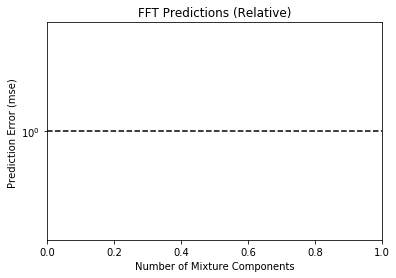

In [1735]:
# Compute "True" FFT error on dev data
linear_errors_per_dataset = []
mlp_errors_per_dataset = []
mlp_errors_two_layer_per_dataset = []
baseline_errors_per_dataset = []
lstm_errors_per_dataset = []
lstm_together_errors_per_dataset = []

relative_errors = True
loss_fn = "mse"

values_of_m = copy.deepcopy(mixture_values)

for m in [2]: #values_of_m:
    dev_mix_ffts = np.array(dev_mixture_datasets[m]['mix_ffts'])
    
    #X_train = copy.deepcopy(get_fft_inputs(train_mixture_datasets[m], train_weighted_ffts))
    #y_train = copy.deepcopy(get_fft_mix_targets(train_mixture_datasets[m]))
    #X_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    
    #X_scaler.fit(X_train)
    #y_scaler.fit(y_train)
    
    X_dev = copy.deepcopy(get_fft_inputs(dev_mixture_datasets[m], dev_weighted_ffts))
    y_dev = copy.deepcopy(dev_mix_ffts)
    #X_dev = X_scaler.transform(X_dev)
    #y_dev = y_scaler.transform(y_dev)
    
    #X_scaler_baseline = StandardScaler()
    source_fft_data = copy.deepcopy(dev_weighted_ffts)
    source_energies = copy.deepcopy(dev_energies)
    #X_scaler_baseline.fit(source_fft_data)
    #source_fft_data = X_scaler_baseline.transform(source_fft_data)
    
    linear_predictions = make_linear_predictions(source_fft_data, dev_mixture_datasets[m]['components'], energy_list = source_energies)
    mlp_predictions = fft_mlp_models[m].predict(X_dev, batch_size=200)  
    mlp_predictions_two_layer = fft_mlp_models_two_layer[m].predict(X_dev, batch_size=200) 
    
    X_dev_lstm = copy.deepcopy(get_fft_inputs(dev_mixture_datasets[m], dev_weighted_ffts, flatten=False))
    lstm_predictions = fft_lstm_models[m].predict(X_dev_lstm, batch_size=200)
    
    lstm_together_predictions = lstm_together_model.predict(X_dev_lstm, batch_size=200)
    
    if relative_errors:
        linear_errors = get_relative_errors(y_dev, linear_predictions, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
        mlp_errors = get_relative_errors(dev_mix_ffts, mlp_predictions, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
        mlp_errors_two_layer = get_relative_errors(dev_mix_ffts, mlp_predictions_two_layer, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
        lstm_errors = get_relative_errors(y_dev, lstm_predictions, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
        lstm_together_errors = get_relative_errors(y_dev, lstm_together_predictions, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
    else:
        linear_errors = get_errors(y_dev, linear_predictions, loss_fn=loss_fn)
        mlp_errors = get_errors(y_dev, mlp_predictions, loss_fn=loss_fn)
        mlp_errors_two_layer = get_errors(y_dev, mlp_predictions_two_layer, loss_fn=loss_fn)
        lstm_errors = get_errors(y_dev, lstm_predictions, loss_fn=loss_fn)
        lstm_together_errors = get_errors(y_dev, lstm_together_predictions, loss_fn=loss_fn)
        baseline_errors = get_baseline_errors(y_dev, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
        baseline_errors_per_dataset.append(baseline_errors)
    
    linear_errors_per_dataset.append(linear_errors)
    mlp_errors_per_dataset.append(mlp_errors)
    mlp_errors_two_layer_per_dataset.append(mlp_errors_two_layer)
    lstm_errors_per_dataset.append(lstm_errors)
    lstm_together_errors_per_dataset.append(lstm_together_errors)
    
    print("Mean Linear Error: ", np.mean(linear_errors), " | Mean MLP Error: ", np.mean(mlp_errors)
         ,"Mean LSTM Error: ", np.mean(lstm_errors), "Mean LSTM Together Error: ", np.mean(lstm_together_errors))
    #_ = plt.hist(errors, bins=50)

handles = [mpatches.Patch(color='black',label='Baseline'),
           mpatches.Patch(color='g',label='Linear Combination'),
           mpatches.Patch(color='r',label='MLP Network'),
           mpatches.Patch(color='c',label='MLP 2-Layer'),
           mpatches.Patch(color='b',label='LSTM Network'),
           mpatches.Patch(color='y',label='LSTM Joint Network')
           ]

if relative_errors:
    plt.title("FFT Predictions (Relative)")
    plt.axhline(y=1, color='black', linestyle='--')
else:
    plt.title("FFT Predictions (Raw)")
    plt.plot(mixture_values, [np.mean(e) for e in baseline_errors_per_dataset], c = 'black', linestyle='--')
    
plt.yscale('log')
    
plt.xlabel("Number of Mixture Components")
plt.ylabel("Prediction Error (%s) " % (loss_fn))

_ = plt.plot(values_of_m, [np.mean(e) for e in linear_errors_per_dataset], c = 'g')
_ = plt.scatter(values_of_m, [np.mean(e) for e in linear_errors_per_dataset], c = 'g')

_ = plt.plot(values_of_m, [np.mean(e) for e in mlp_errors_per_dataset], c = 'r')
_ = plt.scatter(values_of_m, [np.mean(e) for e in mlp_errors_per_dataset], c = 'r')

_ = plt.plot(values_of_m, [np.mean(e) for e in mlp_errors_two_layer_per_dataset], c = 'c')
_ = plt.scatter(values_of_m, [np.mean(e) for e in mlp_errors_two_layer_per_dataset], c = 'c')

_ = plt.plot(values_of_m, [np.mean(e) for e in lstm_errors_per_dataset], c = 'b')
_ = plt.scatter(values_of_m, [np.mean(e) for e in lstm_errors_per_dataset], c = 'b')

_ = plt.plot(values_of_m, [np.mean(e) for e in lstm_together_errors_per_dataset], c = 'y')
_ = plt.scatter(values_of_m, [np.mean(e) for e in lstm_together_errors_per_dataset], c = 'y')

plt.legend(bbox_to_anchor=(1, 1),handles=handles)

Mean Linear Error:  0.4393814966549267  | Mean MLP Error:  0.8264253026640014 Mean LSTM Error:  0.2972907969865805


ValueError: x and y must have same first dimension, but have shapes (7,) and (1,)

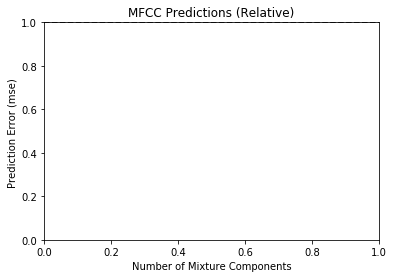

In [1723]:
# Compute "True" MFCC error on dev data
linear_errors_per_dataset = []
mlp_errors_per_dataset = []
mlp_errors_two_layer_per_dataset = []
mlp_fft_errors_per_dataset = []
baseline_errors_per_dataset = []
lstm_errors_per_dataset = []

relative_errors = True
loss_fn = "mse"

values_of_m = copy.deepcopy(mixture_values)

for m in [2]: #values_of_m:
    source_energies = copy.deepcopy(dev_energies)
    dev_mix_mfccs = dev_mixture_datasets[m]['mix_mfccs']
    y_dev = copy.deepcopy(dev_mix_mfccs)
    
    linear_predictions = make_linear_predictions(dev_weighted_mfccs, dev_mixture_datasets[m]['components'], energy_list=source_energies) 
    
    X_dev = copy.deepcopy(get_mfcc_inputs(dev_mixture_datasets[m], dev_weighted_mfccs))
    mlp_predictions = mlp_models[m].predict(X_dev, batch_size=200) 
    mlp_predictions_two_layer = mlp_models_two_layer[m].predict(X_dev, batch_size=200) 

    # Predict MFCC from FFT
    X_dev_fft = copy.deepcopy(get_fft_inputs(dev_mixture_datasets[m], dev_weighted_ffts))
    mlp_fft_predictions = fft_to_mfcc_mlp_models[m].predict(X_dev_fft, batch_size=200)   
    
        
    X_dev_lstm = copy.deepcopy(get_mfcc_inputs(dev_mixture_datasets[m], dev_weighted_mfccs, flatten=False))
    lstm_predictions = lstm_models[m].predict(X_dev_lstm, batch_size=200)
    
    if relative_errors:
        linear_errors = get_relative_errors(y_dev, linear_predictions, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
        mlp_errors = get_relative_errors(y_dev, mlp_predictions, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
        mlp_errors_two_layer = get_relative_errors(y_dev, mlp_predictions_two_layer, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
        mlp_fft_errors = get_relative_errors(y_dev, mlp_fft_predictions, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
        lstm_errors = get_relative_errors(y_dev, lstm_predictions, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
    else:
        linear_errors = get_errors(y_dev, linear_predictions, loss_fn=loss_fn)
        mlp_errors = get_errors(y_dev, mlp_predictions, loss_fn=loss_fn)
        mlp_errors_two_layer = get_errors(y_dev, mlp_predictions_two_layer, loss_fn=loss_fn)
        mlp_fft_errors = get_errors(y_dev, mlp_fft_predictions, loss_fn=loss_fn)
        lstm_errors = get_errors(y_dev, lstm_predictions, loss_fn=loss_fn)
        baseline_errors = get_baseline_errors(y_dev, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
        baseline_errors_per_dataset.append(baseline_errors)

    linear_errors_per_dataset.append(linear_errors)
    mlp_errors_per_dataset.append(mlp_errors)
    mlp_errors_two_layer_per_dataset.append(mlp_errors_two_layer)
    mlp_fft_errors_per_dataset.append(mlp_fft_errors)
    lstm_errors_per_dataset.append(lstm_errors)
    
    
    print("Mean Linear Error: ", np.mean(linear_errors), " | Mean MLP Error: ", np.mean(mlp_errors)
         ,"Mean LSTM Error: ", np.mean(lstm_errors))
    #     ,"Mean MLP-FFT Error: ", np.mean(mlp_fft_errors))

handles = [mpatches.Patch(color='black',label='Baseline'),
           mpatches.Patch(color='g',label='Linear Combination'),
           mpatches.Patch(color='r',label='MLP Network'),
           mpatches.Patch(color='c',label='MLP 2-Layer'),
           mpatches.Patch(color='b',label='LSTM Network')
           ]
    
if relative_errors:
    plt.title("MFCC Predictions (Relative)")
    plt.axhline(y=1, color='black', linestyle='--')
else:
    plt.title("MFCC Predictions (Raw)")
    plt.plot(values_of_m, [np.mean(e) for e in baseline_errors_per_dataset], c = 'black', linestyle='--')

#plt.yscale('log')
    
plt.xlabel("Number of Mixture Components")
plt.ylabel("Prediction Error (%s) " % (loss_fn))

_ = plt.plot(values_of_m, [np.mean(e) for e in linear_errors_per_dataset], c = 'g')
_ = plt.scatter(values_of_m, [np.mean(e) for e in linear_errors_per_dataset], c = 'g')

_ = plt.plot(values_of_m, [np.mean(e) for e in mlp_errors_per_dataset], c = 'r')
_ = plt.scatter(values_of_m, [np.mean(e) for e in mlp_errors_per_dataset], c = 'r')

_ = plt.plot(values_of_m, [np.mean(e) for e in mlp_errors_two_layer_per_dataset], c = 'c')
_ = plt.scatter(values_of_m, [np.mean(e) for e in mlp_errors_two_layer_per_dataset], c = 'c')

_ = plt.plot(values_of_m, [np.mean(e) for e in lstm_errors_per_dataset], c = 'b')
_ = plt.scatter(values_of_m, [np.mean(e) for e in lstm_errors_per_dataset], c = 'b')

#_ = plt.plot(values_of_m, [np.mean(e) for e in mlp_fft_errors_per_dataset], c = 'y')
#_ = plt.scatter(values_of_m, [np.mean(e) for e in mlp_fft_errors_per_dataset], c = 'y')
#handles.append(mpatches.Patch(color='y',label='MLP-FFT Network'))

plt.legend(bbox_to_anchor=(1, 1),handles=handles)

In [222]:
#from tensorflow.python.ops import math_ops

#import keras.backend as K
#def mean_absolute_percentage_error(y_true, y_pred):
#  diff = math_ops.abs(
#      (y_true - y_pred) / K.clip(math_ops.abs(y_true), K.epsilon(), None))
#  return 100. * K.mean(diff, axis=-1)


In [214]:
#mean_absolute_percentage_error(np.array([0.7]),np.array([0.3]))

In [192]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [1403]:
np.pi

3.141592653589793

In [1468]:
freqs = librosa.core.fft_frequencies()
sr = 22050

In [1469]:
freqs[0:20]

array([  0.        ,  10.76660156,  21.53320312,  32.29980469,
        43.06640625,  53.83300781,  64.59960938,  75.36621094,
        86.1328125 ,  96.89941406, 107.66601562, 118.43261719,
       129.19921875, 139.96582031, 150.73242188, 161.49902344,
       172.265625  , 183.03222656, 193.79882812, 204.56542969])

In [ ]:
"""
    sine_sum = np.array([librosa.core.tone(frequency=frequencies[i],length=window_size)*magnitudes[i] for i in range(len(frequencies))]).sum(axis=0)/len(frequencies)
    
   
    
    data = sine_sum * window
    #n_windows = int(window_size/hop_size)
 
    #windows = [np.concatenate([np.zeros(hop_size*i), window, window])[window_size:2*window_size] for i in range(n_windows)]

    olap = window_size / hop_size
    n_samples = int((duration * sr))
    n_loops = int(n_samples / hop_size - 1)
    
    out_v = np.zeros(n_samples + window_size)
    
    p =0
    
    for i in range (0, n_loops):
        
        for k in range (0, window_size):
            out_v[p + k] += data[k] / olap;
            
        p = p + hop_size        
    
    return out_v
"""

    #sine_sums = [np.concatenate([np.zeros(hop_size*i), sine_sum, sine_sum])[len(sine_sum):2*len(sine_sum)] for i in range(n_windows)]
 
    #sines = [sine_sum*w for w in windows]
    #sines = np.tile(sine_sum, int(np.ceil(n_samples / window_size)))[0:n_samples]
    #return sines
    #sines = [np.tile(s, int(np.ceil(n_samples / window_size)))[0:n_samples] for s in sines]
    
    #print(n_windows)
    
    #repeated_window = np.tile(window, int(np.ceil(n_samples / hop_size)))[0:n_samples]
    #windows = [np.concatenate([np.zeros(hop_size*i), repeated_window])[0:n_samples] for i in range(n_windows)]
    #windowed_wave = np.sum([w*sines for w in windows],axis=0)/n_windows
    #return windowed_wave
    

    #n_windows = int(np.ceil(n_samples / hop_size))
    #windows = [librosa.util.fix_length(np.concatenate([np.zeros(hop_size*i), window])[0:n_samples], n_samples) for i in range(n_windows)]
    #for i in range(len(sines)):
    #    sines[i] = [sines[i]*windows]
    
    
    
    #print(n_windows)
    #
    #window_sum = np.sum(windows, axis=0)
    #plt.plot(window_sum)
    #signal = np.sum([w*sines for w in windows], axis=0)/n_windows
    #signal = np.sum([sines*windows[i] for i in range(len(windows))], axis=0)/n_windows
    #return signal

In [1518]:


def spec_synth(magnitudes, frequencies, duration=2, window_size=1024, hop_size=256):

    
    n_samples = duration*sr
    window = librosa.filters.get_window(window='hann', Nx=window_size)
    
    out_samples = []
    
    for i in tqdm(range(n_samples)):
        v = 0.
        for j in range(len(peaks)):
            v+= magnitudes[peaks[j]]*np.sin(2*np.pi*frequencies[peaks[j]]*i/sr)
        out_samples.append(v)
            
    return out_samples
        

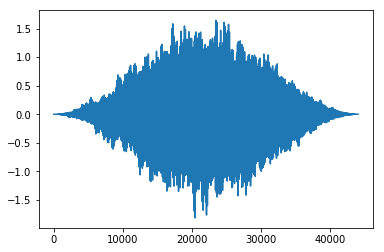

In [1597]:
def interpolate_frequencies(magnitudes, frequencies):
    new_mags = []
    new_freqs = []
    for i in range(1, len(frequencies)-1):
        mags = [magnitudes[i-1], magnitudes[i], magnitudes[i+1]]
        freqs = [frequencies[i-1], frequencies[i], frequencies[i+1]]
        new_freq = np.dot(mags, freqs) / np.sum(mags)
        new_mag = np.mean(mags)
        new_mags.append(new_mag)
        new_freqs.append(new_freq)
    return new_freqs

def pick_peaks(magnitudes, threshold=0):
    peaks = []
    for i in range(1, len(magnitudes)-1):
        if magnitudes[i] > magnitudes[i-1] and magnitudes[i] > magnitudes[i+1] and magnitudes[i]>threshold:
            peaks.append(i)
    return peaks

def spectrum_synth(magnitudes, frequencies, duration=2, window_size=1024, hop_size=256, threshold=0):
    #frequencies = copy.deepcopy(frequencies[100:150])
    #magnitudes = copy.deepcopy(magnitudes[100:150])
    peaks = pick_peaks(magnitudes[1:int(len(magnitudes)/2)], threshold=threshold)
    
    n_samples = int((duration * sr))
    window = librosa.filters.get_window(window='hann', Nx=n_samples)

    out_samples = np.array([librosa.core.tone(frequencies[peaks[j]], length=n_samples) * magnitudes[peaks[j]] for j in range(0, len(peaks))]).sum(axis=0)/len(peaks)
    #out_samples =[]
    #for i in range(n_samples):
    #    v = 0.
    #    for j in range(len(peaks)):
    #        v += magnitudes[peaks[j]]*np.sin(2*np.pi*frequencies[peaks[j]]*i/sr)
    #    out_samples.append(v)
            
    out_samples *= window
        
    return out_samples

new_frequencies = interpolate_frequencies(spectrum, freqs)
signal = spectrum_synth(spectrum[1:], new_frequencies, threshold=0.1)
plt.plot(signal)
play(signal, rate=sr)


In [1608]:
#linear_predictions
#mlp_predictions
#mlp_predictions_two_layer
#lstm_predictions
#lstm_together_predictions

In [1621]:
index = 2
m = 2

In [1647]:
#ORIGINAL
play(dev_mixture_datasets[m]['mixes'][index], rate=sr)

In [1649]:
components = dev_mixture_datasets[m]['components'][index]
components

array([2036,  432])

In [1681]:
play(dev_signals[components[0]], rate=sr)
#play(dev_signals[components[1]], rate=sr)

In [1682]:
spectrum1 = dev_weighted_ffts[components[0]]
spectrum2 = dev_weighted_ffts[components[1]]

array([array([-5.9400072e-06, -8.5365442e-05, -2.8901195e-04, ...,
       -1.9842360e-02, -9.0223690e-03,  0.0000000e+00], dtype=float32),
       array([ 2.5380155e-06, -2.5913419e-06,  2.1927555e-05, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
       array([-1.9266632e-05, -1.4249879e-04, -1.7417171e-04, ...,
       -9.3802091e-06, -2.6334632e-05,  0.0000000e+00], dtype=float32),
       ...,
       array([ 5.6344777e-07, -1.0340655e-05, -4.5180899e-05, ...,
        1.5270464e-06,  5.4704419e-06,  0.0000000e+00], dtype=float32),
       array([-5.8589885e-05,  2.9024360e-04,  1.3629299e-04, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
       array([-7.2911830e-06, -6.1621438e-05, -1.6705415e-04, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)],
      dtype=object)

In [1676]:
S, phase = librosa.magphase(librosa.stft(dev_signals[components[0]]))
rms = librosa.feature.rmse(S=S)
result = np.sum(S*rms, axis=1)/np.sum(rms)

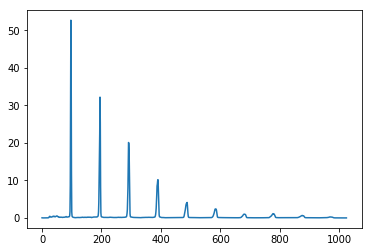

In [1686]:
plt.plot(result)

In [1697]:
dev_files[components[0]]

'/data/jrgillick/projects/assisted_orchestration/OrchDB/OrchDB_flat/Vns-ord-C6-f.wav'

array([2036,  432])

In [1696]:
dev_mixture_datasets[2]['components'][0]

array([ 932, 2736])

In [1701]:
sum_2 = make_linear_predictions(dev_weighted_ffts, [components], energy_list = dev_energies)[0]

In [ ]:
plt.plot(spectrum_real)

In [1742]:
#sum_component_ffts(fft_list, component_indices, energy_list=None, energy_weighted=True)

In [1746]:
diff = dev_mixture_datasets[2]['mix_ffts'][index] - lstm_predictions[index]
np.sqrt(np.sum(diff*diff))

39.071594

In [1745]:
diff = dev_mixture_datasets[2]['mix_ffts'][index] - linear_predictions[index]
np.sqrt(np.sum(diff*diff))

48.272785

In [1747]:
mean_absolute_percentage_error(dev_mixture_datasets[2]['mix_ffts'][index], lstm_predictions[index])

4.468351753048781

In [1748]:
mean_absolute_percentage_error(dev_mixture_datasets[2]['mix_ffts'][index], linear_predictions[index])

1.578935546875

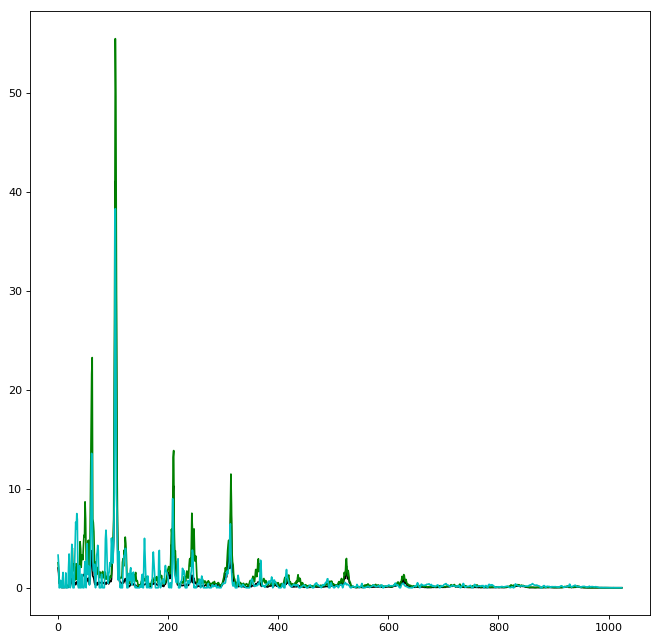

In [1740]:
index = 5
fig = plt.figure(figsize=(10,10),dpi=80)
plt.plot(dev_mixture_datasets[2]['mix_ffts'][index], c='black')
plt.plot(linear_predictions[index],c='g')
#plt.plot(mlp_predictions[index],c='r')
plt.plot(lstm_predictions[index],c='c')
#plt.plot(spectrum1, c='r')
#plt.plot(spectrum2, c='c')
#plt.plot((spectrum1+spectrum2)/2,c='black')

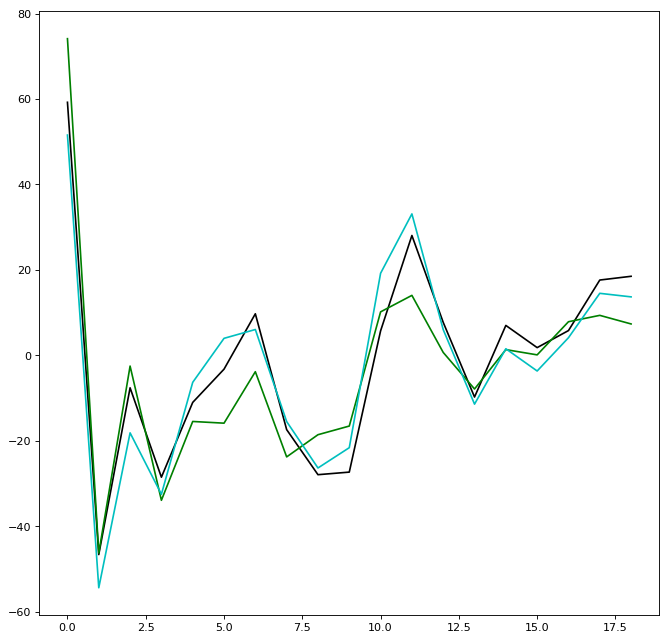

In [1734]:
index = 5
fig = plt.figure(figsize=(10,10),dpi=80)
plt.plot(dev_mixture_datasets[2]['mix_mfccs'][index], c='black')
plt.plot(linear_predictions[index],c='g')
#plt.plot(mlp_predictions[index],c='r')
plt.plot(lstm_predictions[index],c='c')
#plt.plot(spectrum1, c='r')
#plt.plot(spectrum2, c='c')
#plt.plot((spectrum1+spectrum2)/2,c='black')

In [1724]:
# Synthesized from Real Features
spectrum_real = dev_mixture_datasets[m]['mix_ffts'][index]; new_frequencies = interpolate_frequencies(spectrum, freqs)
play(spectrum_synth(spectrum_real[1:], new_frequencies, threshold=0.1, duration=4), rate=sr)

In [1725]:
mfcc_real = dev_mixture_datasets[m]['mix_mfccs'][index]

In [1708]:
# Synthesized from Linear combination 
spectrum_linear = linear_predictions[index]
new_frequencies = interpolate_frequencies(spectrum, freqs)
play(spectrum_synth(spectrum_linear[1:], new_frequencies, threshold=0.1, duration=4), rate=sr)

In [1711]:
# Synthesized from MLP predictions 
spectrum_mlp = mlp_predictions[index]; new_frequencies = interpolate_frequencies(spectrum, freqs)
play(spectrum_synth(spectrum_mlp[1:], new_frequencies, threshold=0.1, duration=4), rate=sr)

In [1710]:
# Synthesized from LSTM predictions 
spectrum_lstm = lstm_predictions[index]#; new_frequencies = interpolate_frequencies(spectrum, freqs)
play(spectrum_synth(spectrum_lstm[1:], new_frequencies, threshold=0.1, duration=4), rate=sr)

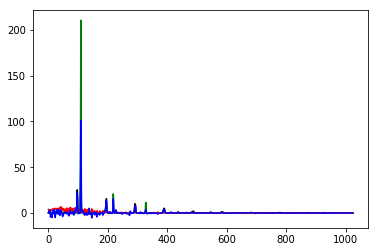

In [1712]:
plt.plot(spectrum_real, c='black')
plt.plot(spectrum_linear, c='g')
plt.plot(spectrum_mlp, c='r')
plt.plot(spectrum_lstm, c='b')

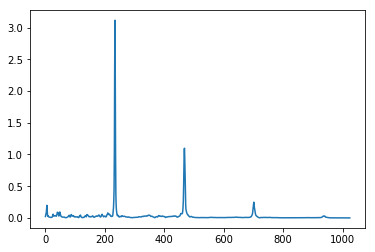

In [1532]:
plt.plot(spectrum)

In [1537]:
peaks = pick_peaks(spectrum, threshold=0.1)
len(peaks)
peaks

[5, 234, 468, 701]

In [1477]:
window_size=1024

In [1484]:
sine_sum = np.array([librosa.core.tone(frequency=freqs[i],length=window_size) for i in range(len(freqs))]).sum(axis=0)/len(freqs)
window = librosa.filters.get_window(window='hann', Nx=window_size)

(1025,)

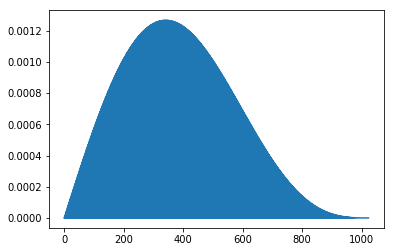

In [1485]:
plt.plot(sine_sum*window)
freqs.shape

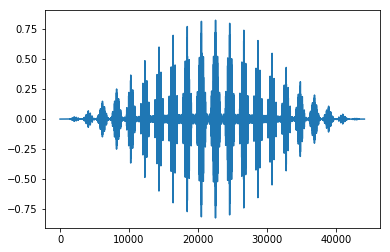

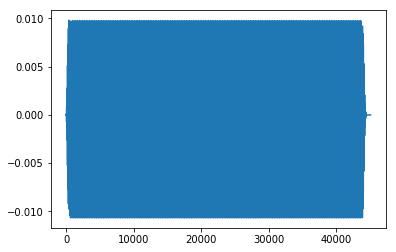

In [1449]:
plt.plot(signal)

In [1452]:
spec = librosa.core.stft(signal, n_fft=1024, hop_length=256)

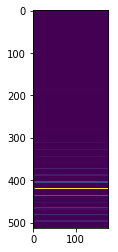

In [1487]:
np.sin??

In [1400]:
play(sig,rate=sr)

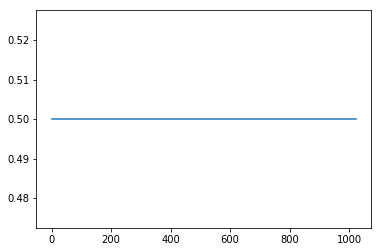

In [1423]:
plt.plot(np.sum(windows, axis=0)/len(windows))

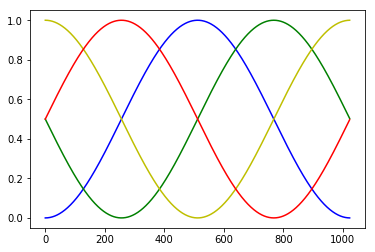

In [1372]:
plt.plot((windows[0]), c='b')
plt.plot((windows[1]), c='g')
plt.plot((windows[2]), c='y')
plt.plot((windows[3]), c='r')

In [1373]:
len(windows[0])

1024

In [1374]:
sines = np.sum([sine_sum*w for w in windows],axis=0)
s = np.tile(sines, 40)

In [1375]:
play(s, rate=sr)

173


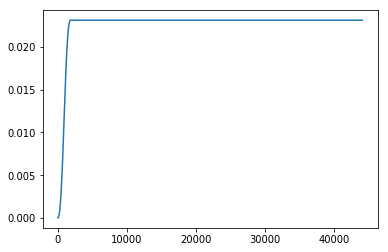

In [1300]:
n_samples = 44100
window_size=2048
hop_size=256
window = librosa.filters.get_window(window='hann', Nx=window_size)
n_windows = int(np.ceil(n_samples / hop_size))
print(n_windows)
windows = [librosa.util.fix_length(np.concatenate([np.zeros(hop_size*i), window])[0:n_samples], n_samples) for i in range(n_windows)]
wq = np.sum(windows, axis=0)/n_windows
plt.plot(wq)

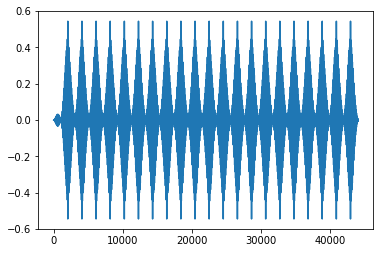

In [948]:
spectrum = train_weighted_ffts[15]
sounds = spectrum_synth(spectrum, freqs)
plt.plot(sounds)

In [949]:
play(sounds, rate=sr)

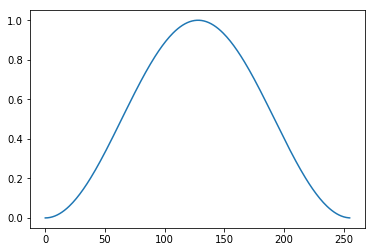

In [793]:
window = librosa.filters.get_window('hanning', Nx=256)

In [866]:
play(all_wav_files[12], rate=sr)

In [770]:
np.tile(sines, 3).shape

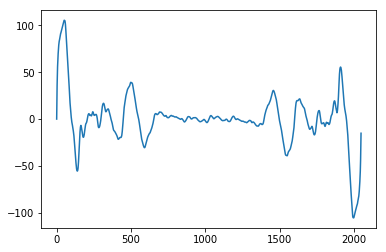

Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x7fdbdeb048d0>>
Traceback (most recent call last):
  File "/home/jrgillick/.pyenv/versions/3.6.0/lib/python3.6/wave.py", line 316, in __del__
    self.close()
  File "/home/jrgillick/.pyenv/versions/3.6.0/lib/python3.6/wave.py", line 434, in close
    self._ensure_header_written(0)
  File "/home/jrgillick/.pyenv/versions/3.6.0/lib/python3.6/wave.py", line 454, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


In [739]:
play(librosa.core.tone(frequency=freqs[20],length=2048), rate=sr)

In [533]:
preds_20 = np.array(dev_mixture_datasets[20]['baseline_predicted_mix_mfccs'])
true_20 = np.array(dev_mixture_datasets[20]['mix_mfccs'])

preds_2 = np.array(dev_mixture_datasets[2]['baseline_predicted_mix_mfccs'])
true_2 = np.array(dev_mixture_datasets[2]['mix_mfccs'])

In [572]:
#np.std(true_20, axis=0)
#np.std(preds_20, axis=0)
#np.std(true_2, axis=0)
#np.std(preds_2, axis=0)

In [561]:
import matplotlib.patches as mpatches

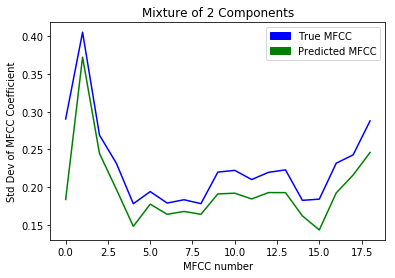

In [564]:
plt.title("Mixture of 2 Components")
plt.xlabel("MFCC number")
plt.ylabel("Std Dev of MFCC Coefficient")
plt.plot(np.std(true_2, axis=0), c='b')
_ = plt.plot(np.std(preds_2, axis=0), c='g')

handles = [mpatches.Patch(color='b',label='True MFCC'),mpatches.Patch(color='g',label='Predicted MFCC')] #for i, t in enumerate(list(set(descriptor_list)))]
plt.legend(bbox_to_anchor=(1, 1),handles=handles)

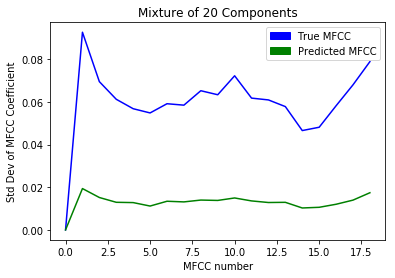

In [565]:
plt.title("Mixture of 20 Components")
plt.xlabel("MFCC number")
plt.ylabel("Std Dev of MFCC Coefficient")
plt.plot(np.std(true_20, axis=0), c='b')
plt.plot(np.std(preds_20, axis=0), c='g')

handles = [mpatches.Patch(color='b',label='True MFCC'),mpatches.Patch(color='g',label='Predicted MFCC')] #for i, t in enumerate(list(set(descriptor_list)))]
plt.legend(bbox_to_anchor=(1, 1),handles=handles)

In [511]:
from sklearn.metrics import mean_squared_error

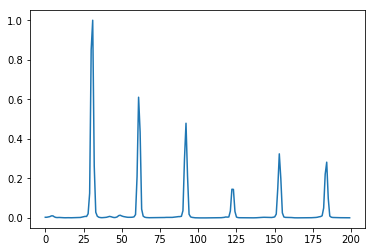

In [341]:
plt.plot(train_weighted_ffts[186][0:200])

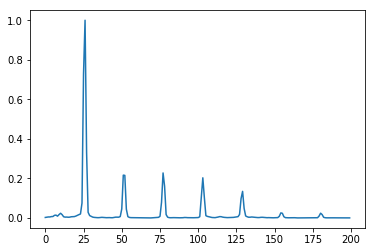

In [343]:
plt.plot(train_weighted_ffts[421][0:200])

<h3> Experiments with Autoencoders </h3>

In [20]:
all_mean_mfcc = []
for i in tqdm(range(len(all_wav_files))):
    y, sr = librosa.load(all_wav_files[i], duration=max_duration)
    all_mean_mfcc.append(np.mean(librosa.feature.mfcc(y, n_mfcc=13), axis=1))

100%|██████████| 1532/1532 [02:19<00:00, 10.99it/s]


In [434]:
mfcc_data = [m[1:] for m in all_mean_mfcc]

In [275]:
all_mfcc = []
for i in tqdm(range(len(all_wav_files))):
    y, sr = librosa.load(all_wav_files[i], duration=max_duration)
    all_mfcc.append(librosa.feature.mfcc(y, n_mfcc=13))

100%|██████████| 1532/1532 [04:15<00:00,  5.04it/s]


In [438]:
good_indices = []
for i, m in enumerate(all_mfcc):
    if m.shape==(13, 87):
        good_indices.append(i)

In [440]:
full_mfcc_data = [m[1:,:].reshape(-1) for m in all_mfcc if m.shape==(13, 87)] #exclude ones that were shorter than 2 seconds

In [441]:
mfcc_data = [m for i, m in enumerate(mfcc_data) if i in good_indices]

In [442]:
from sklearn.utils import shuffle
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Dropout
import keras.optimizers

In [311]:
def initialize_autoencoder():
    model = Sequential()
    model.add(Dense(100, use_bias=True,input_dim=12*87))
    model.add(keras.layers.BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Activation("relu"))
    model.add(Dense(12, use_bias=True))
    model.add(keras.layers.BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(100, use_bias=True))
    model.add(keras.layers.BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Activation("relu"))
    model.add(Dense(12*87, use_bias=True))
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mean_squared_error'])
    return model 

In [483]:
train = np.array(full_mfcc_data[0:1000])
dev = np.array(full_mfcc_data[1000:])

In [318]:
model = initialize_autoencoder()
model.fit(np.array(train), np.array(train), validation_data=(dev,dev), epochs=50)
model.evaluate(np.array(train), np.array(train))

In [484]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)
dev = scaler.transform(dev)

(495, 1044)

In [523]:
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras import backend as K
from keras.losses import mse

original_dim = 12*87
batch_size = 5
intermediate_dim = 100
latent_dim=50

# VAE model = encoder + decoder
# build encoder model

inputs = Input(batch_shape=(batch_size, original_dim))
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dropout(rate=0.5)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
#encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dropout(rate=0.5)(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
#decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

optimizer = keras.optimizers.Adam()
vae.compile(optimizer=optimizer)

/home/jrgillick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.


In [528]:
for e in range(10):
    vae.fit(train, batch_size=5)
    print(vae.evaluate(dev, batch_size=5))

Epoch 1/1
495/495 [==============================] - 0s 461us/step
686.9288064975931
Epoch 1/1
495/495 [==============================] - 0s 538us/step
674.4179724491004
Epoch 1/1
495/495 [==============================] - 0s 578us/step
683.6457510283499
Epoch 1/1
495/495 [==============================] - 0s 567us/step
693.5525506530145
Epoch 1/1
495/495 [==============================] - 0s 561us/step
678.7203156442354
Epoch 1/1
495/495 [==============================] - 0s 569us/step
680.6198650321575
Epoch 1/1
495/495 [==============================] - 0s 505us/step
682.0862722685843
Epoch 1/1
495/495 [==============================] - 0s 575us/step
679.473589656329
Epoch 1/1
495/495 [==============================] - 0s 553us/step
674.7114128343986
Epoch 1/1
495/495 [==============================] - 0s 465us/step
690.9737986555003


In [531]:
scaled_mfcc_data = np.vstack([train,dev])

In [545]:
mfcc_encodings=np.array(encoder.predict(np.array(scaled_mfcc_data), batch_size=5))[0,:,:]
mfcc_encodings = list(np.array(mfcc_encodings).squeeze())

In [546]:
#mfcc_encodings = [encoder.predict(np.array(scaled_mfcc_data[i:i+1]))[0] for i in tqdm(range(len(scaled_mfcc_data)))]
#mfcc_encodings = list(np.array(mfcc_encodings).squeeze())

<h3> Some Visualizations with PCA/TSNE </h3>

In [547]:
instrument_types = [get_instrument_type(f) for i, f in enumerate(all_wav_files) if i in good_indices]
instruments = [get_instrument(f) for i, f in enumerate(all_wav_files) if i in good_indices]
pitch_classes = [get_pitch_class(f) for i, f in enumerate(all_wav_files) if i in good_indices]
octaves = [get_octave(f) for i, f in enumerate(all_wav_files) if i in good_indices]

n_instrument_types = len(set(instrument_types))
n_instruments = len(set(instruments))
n_pitch_classes = len(set(pitch_classes))
n_octaves = len(set(octaves))

print("Instrument types: ", n_instrument_types)
print("Instruments: ", n_instruments)
print("Pitch Classes: ", n_pitch_classes)
print("Octaves: ", n_octaves)

Instrument types:  3
Instruments:  12
Pitch Classes:  7
Octaves:  8


In [548]:
np.array(mfcc_encodings).shape

(1495, 50)

In [549]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

pca = PCA(n_components=2)
pca_result = pca.fit_transform(mfcc_data)
pca_result_vae = pca.fit_transform(mfcc_encodings)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000)
tsne_result = tsne.fit_transform(mfcc_data)
tsne_result_vae = tsne.fit_transform(mfcc_encodings)

df = pd.DataFrame({'mfcc': mfcc_data,
                   'instrument_type': instrument_types,
                   'instrument': instruments,
                   'pitch_class': pitch_classes,
                   'octave': octaves,
                   'pca_1': list(pca_result[:,0]),
                   'pca_2': list(pca_result[:,1]), #'pca_3': list(pca_result[:,2]),
                   'tsne_1': list(tsne_result[:,0]),
                   'tsne_2': list(tsne_result[:,1]), #'tsne_3': list(tsne_result[:,2]),
                   'pca_vae_1': list(pca_result_vae[:,0]),
                   'pca_vae_2': list(pca_result_vae[:,1]), #'pca_vae_3': list(pca_result_vae[:,2]),
                   'tsne_vae_1': list(tsne_result_vae[:,0]),
                   'tsne_vae_2': list(tsne_result_vae[:,1]), #'tsne_vae_3': list(tsne_result_vae[:,2]),                   
                  })

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1495 samples in 0.002s...
[t-SNE] Computed neighbors for 1495 samples in 0.113s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1495
[t-SNE] Computed conditional probabilities for sample 1495 / 1495
[t-SNE] Mean sigma: 11.315801
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.286293
[t-SNE] KL divergence after 3000 iterations: 0.612893
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1495 samples in 0.002s...
[t-SNE] Computed neighbors for 1495 samples in 0.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1495
[t-SNE] Computed conditional probabilities for sample 1495 / 1495
[t-SNE] Mean sigma: 1.697508
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.556290
[t-SNE] KL divergence after 3000 iterations: 0.604791


In [550]:
from mpl_toolkits.mplot3d import Axes3D

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','b', 'g', 'r', 'c', 'm', 'y', 'k']

# d can be 'instrument_type', 'instrument', 'pitch_class', 'octave', etc.
def plot_by_descriptor(descriptor_list, descriptor_name, plot_type='pca', dims=2):
    if dims==3:
        fig = plt.figure(figsize=(8,8),dpi=80)
        ax = fig.add_subplot(111, projection='3d')
    for i, name in enumerate(list(set(descriptor_list))):
        data = df[df[descriptor_name]==name]
        if plot_type=='pca':
            if dims==3:
                #ax.scatter(data.pca_1, data.pca_2, data.pca_3, c=colors[i])
                ax.scatter(data.pca_vae_1, data.pca_vae_2, data.pca_3, c=colors[i])
            else:
                plt.scatter(data.pca_1, data.pca_2, c=colors[i])
        elif plot_type=='tsne':
            if dims==3:
                #ax.scatter(data.tsne_1, data.tsne_2, data.tsne_3, c=colors[i])
                ax.scatter(data.tsne_vae_1, data.tsne_vae_2, data.tsne_3, c=colors[i])
            else:
                plt.scatter(data.tsne_vae_1, data.tsne_vae_2, c=colors[i])
    
    handles = [mpatches.Patch(color=colors[i],label=t) for i, t in enumerate(list(set(descriptor_list)))]
    plt.legend(bbox_to_anchor=(1, 1),handles=handles)
    plt.show()

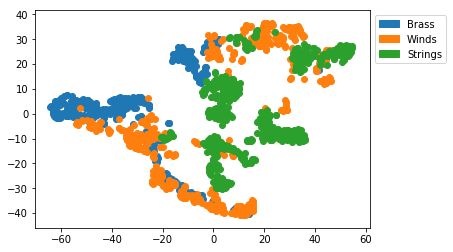

In [551]:
plot_by_descriptor(instrument_types, 'instrument_type', plot_type='tsne', dims=2)

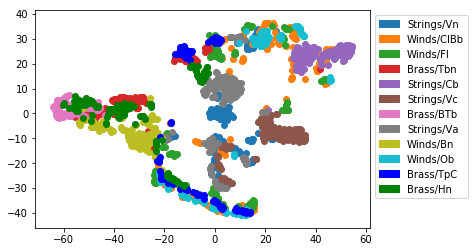

In [555]:
plot_by_descriptor(instruments, 'instrument', plot_type='tsne', dims=2)

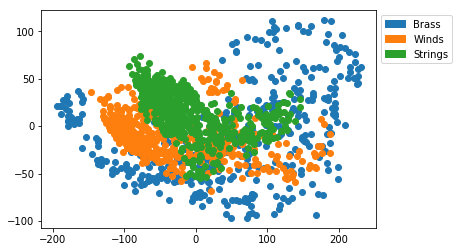

In [554]:
plot_by_descriptor(instrument_types, 'instrument_type', plot_type='pca', dims=2)